지표 생성 중... 완료!

데이터셋 크기 - Train: 204,203, Val: 90,981, Test: 142,061
모델 학습 시작 (Early Stopping 적용)...
학습 완료! (Best Iteration: 87)

✅ 모델 예측 정확도 (IC): 0.0303
   (참고: 0.03 이상이면 유의미, 0.05 이상이면 매우 우수)

백테스트 시뮬레이션 중 (Monthly Rebalancing)...

 최종 성과 보고서 (2022.01 ~ 2024.12)
 * 리밸런싱: 월 1회 (매월 초)
 * 거래비용: 0.2% 적용 완료
지표              | AI Top 10    | KOSPI 200   
--------------------------------------------------
누적 수익률          |       -27.0% |         7.0%
연환산(CAGR)       |       -10.2% |         2.3%
MDD (최대낙폭)      |       -30.8% |       -15.2%
Sharpe Ratio    |       -0.30  |        0.22
--------------------------------------------------


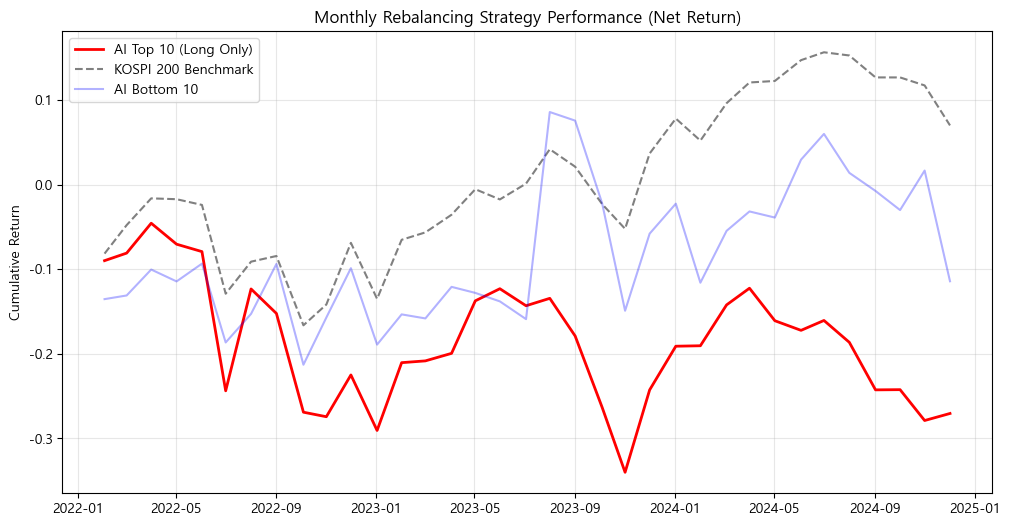

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정 (Colab 등 환경에 맞춰 설정 필요, 깨짐 방지용)
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

# ==============================================================================
# 1. 데이터 병합 및 전처리
# ==============================================================================
# 가상의 df1(가격), df2(수급)가 있다고 가정하고 병합합니다.
# 실제 사용 시 df1, df2는 로드된 상태여야 합니다.

df1 = pd.read_csv('../단기모멘텀.csv', dtype={'ticker':str})
df2 = pd.read_csv('../24.12_수급,거래 데이터.csv', dtype={'ticker':str})

df1['date'] = pd.to_datetime(df1['date'])
df2['date'] = pd.to_datetime(df2['date'])
df1['ticker'] = df1['ticker'].astype(str)
df2['ticker'] = df2['ticker'].astype(str)

# df1(가격) 기준으로 df2(수급) 병합 (Left Join)
df = pd.merge(df1, df2, on=['date', 'ticker'], how='left')

# 수급 데이터 결측치는 0으로 채움 (데이터 없음 = 순매수 0)
investor_cols = ['기관_순매수_수량', '개인_순매수_수량', '외국인_순매수_수량',
                 '기관_순매수_금액', '개인_순매수_금액', '외국인_순매수_금액']
df[investor_cols] = df[investor_cols].fillna(0)

# 날짜/종목순 정렬
df = df.sort_values(['ticker', 'date'])

# ==============================================================================
# 2. Feature Engineering (최대 20일 제한 -> 데이터 손실 최소화)
# ==============================================================================
print("지표 생성 중...", end="")

# (1) 추세: 이격도 (5일, 20일)
for w in [5, 20]:
    ma = df.groupby('ticker')['종가'].rolling(window=w).mean().reset_index(0, drop=True)
    df[f'disparity_{w}'] = df['종가'] / ma

# (2) 모멘텀: RSI (14일)
def calc_rsi(x, window=14):
    delta = x.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / (loss + 1e-9)
    return 100 - (100 / (1 + rs))
df['rsi_14'] = df.groupby('ticker')['종가'].transform(lambda x: calc_rsi(x))

# (3) 추세: MACD (12, 26, 9)
def calc_macd(x):
    exp12 = x.ewm(span=12, adjust=False).mean()
    exp26 = x.ewm(span=26, adjust=False).mean()
    macd = exp12 - exp26
    signal = macd.ewm(span=9, adjust=False).mean()
    return macd - signal
df['macd_osc'] = df.groupby('ticker')['종가'].transform(lambda x: calc_macd(x))

# (4) 변동성: 볼린저 밴드 %B (20일)
def calc_bb(x, window=20):
    ma = x.rolling(window=window).mean()
    std = x.rolling(window=window).std()
    upper = ma + (std * 2)
    lower = ma - (std * 2)
    return (x - lower) / (upper - lower + 1e-9)
df['bollinger_pb'] = df.groupby('ticker')['종가'].transform(lambda x: calc_bb(x))

# (5) 변동성: 5일 등락률 표준편차
df['volatility_5'] = df.groupby('ticker')['등락률'].rolling(window=5).std().reset_index(0, drop=True)

# (6) 수급: 주체별 누적 순매수 (5일, 20일)
# 금액 데이터가 있으면 금액 우선, 없으면 수량 사용
target_inv_col = '순매수_금액' if '외국인_순매수_금액' in df.columns else '순매수_수량'
for subject in ['외국인', '기관', '개인']:
    col_name = f'{subject}_{target_inv_col}'
    if col_name in df.columns:
        df[f'{col_name}_sum_5'] = df.groupby('ticker')[col_name].rolling(window=5).sum().reset_index(0, drop=True)
        df[f'{col_name}_sum_20'] = df.groupby('ticker')[col_name].rolling(window=20).sum().reset_index(0, drop=True)

# (7) 거래량: 회전율 (5일 vs 20일)
v_5 = df.groupby('ticker')['거래량'].rolling(window=5).mean().reset_index(0, drop=True)
v_20 = df.groupby('ticker')['거래량'].rolling(window=20).mean().reset_index(0, drop=True)
df['volume_ratio'] = v_5 / (v_20 + 1e-9)

print(" 완료!")

# ==============================================================================
# 3. Target 생성 (Rank Prediction)
# ==============================================================================
# (1) 10일 후 수익률 계산
df['target_10d'] = df.groupby('ticker')['종가'].shift(-10) / df['종가'] - 1

# (2) 날짜별 수익률 순위 산출 (0.0 ~ 1.0, 1.0이 1등)
df['target_rank'] = df.groupby('date')['target_10d'].rank(pct=True)

# (3) 사용할 Feature 목록 정의 (Max 20일)
features = [
    'disparity_5', 'disparity_20',
    'rsi_14', 'macd_osc', 'bollinger_pb', 'volatility_5', 'volume_ratio'
]
# 수급 컬럼 자동 추가
features += [c for c in df.columns if 'sum_5' in c or 'sum_20' in c]

# 결측치 제거
model_df = df.dropna(subset=features + ['target_rank']).copy()

# ==============================================================================
# 4. 데이터 분할 (Train / Val / Test)
# ==============================================================================
train = model_df[model_df['date'].between('2015-01-01', '2019-12-31')]
val   = model_df[model_df['date'].between('2020-01-01', '2021-12-31')]
test  = model_df[model_df['date'].between('2022-01-01', '2024-12-31')]

print(f"\n데이터셋 크기 - Train: {len(train):,}, Val: {len(val):,}, Test: {len(test):,}")

# ==============================================================================
# 5. XGBoost 모델링 (Ranking 학습)
# ==============================================================================
model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50
)

print("모델 학습 시작 (Early Stopping 적용)...")
model.fit(
    train[features], train['target_rank'],
    eval_set=[(train[features], train['target_rank']), (val[features], val['target_rank'])],
    verbose=0 # 로그 출력 생략
)
print(f"학습 완료! (Best Iteration: {model.best_iteration})")

# ==============================================================================
# 6. 정확도 검증 (IC: Information Coefficient)
# ==============================================================================
test_copy = test.copy()
test_copy['pred_rank'] = model.predict(test_copy[features])

# 예측 순위와 실제 순위의 상관관계 측정
ic = test_copy[['target_rank', 'pred_rank']].corr(method='spearman').iloc[0, 1]
print(f"\n✅ 모델 예측 정확도 (IC): {ic:.4f}")
print("   (참고: 0.03 이상이면 유의미, 0.05 이상이면 매우 우수)")

# ==============================================================================
# 7. 월간 리밸런싱 백테스트 (수수료 0.2% 적용)
# ==============================================================================
print("\n백테스트 시뮬레이션 중 (Monthly Rebalancing)...")

# 월초 날짜 추출
monthly_dates = sorted(test_copy.groupby([test_copy['date'].dt.year, test_copy['date'].dt.month])['date'].min().values)
monthly_log = []
cost = 0.002 # 수수료 0.2%

for i in range(len(monthly_dates) - 1):
    buy_date = monthly_dates[i]
    sell_date = monthly_dates[i+1]

    # 매수일 데이터 추출
    day_data = test_copy[test_copy['date'] == buy_date]
    if len(day_data) < 20: continue

    # [Top 10] 예측 점수가 높은 상위 10개 (Long)
    top_10 = day_data.sort_values(by='pred_rank', ascending=False).head(10)['ticker'].tolist()
    
    # [Bottom 10] 예측 점수가 낮은 하위 10개 (Short 관점)
    bottom_10 = day_data.sort_values(by='pred_rank', ascending=True).head(10)['ticker'].tolist()

    # 구간 수익률 계산 함수
    def calc_return(tickers, d1, d2):
        p1 = test_copy[(test_copy['date'] == d1) & (test_copy['ticker'].isin(tickers))].set_index('ticker')['종가']
        p2 = test_copy[(test_copy['date'] == d2) & (test_copy['ticker'].isin(tickers))].set_index('ticker')['종가']
        valid = p1.index.intersection(p2.index)
        if len(valid) == 0: return 0.0
        return ((p2[valid] / p1[valid]) - 1).mean()

    # 수익률 계산 (Top 10은 수수료 차감)
    r_top = calc_return(top_10, buy_date, sell_date) - cost
    r_bottom = calc_return(bottom_10, buy_date, sell_date) - cost # 비교를 위해 얘도 차감
    r_bm = calc_return(day_data['ticker'].unique(), buy_date, sell_date) # 벤치마크 (KOSPI200)

    monthly_log.append({'date': sell_date, 'Strategy': r_top, 'Benchmark': r_bm, 'Bottom10': r_bottom})

res = pd.DataFrame(monthly_log).set_index('date')
cum_ret = (1 + res).cumprod() - 1

# ==============================================================================
# 8. 성과 지표 산출 (CAGR, MDD, Sharpe)
# ==============================================================================
def calculate_metrics(series):
    # 누적 수익률
    total_ret = (1 + series).cumprod().iloc[-1] - 1
    # CAGR (월간 데이터이므로 12 곱함)
    cagr = (1 + total_ret) ** (12 / len(series)) - 1
    # MDD
    wealth = (1 + series).cumprod()
    peak = wealth.cummax()
    mdd = ((wealth - peak) / peak).min()
    # Sharpe (무위험이자율 0 가정)
    sharpe = (series.mean() / series.std()) * np.sqrt(12)
    return total_ret, cagr, mdd, sharpe

strat_metrics = calculate_metrics(res['Strategy'])
bm_metrics = calculate_metrics(res['Benchmark'])

print("\n" + "="*50)
print(f" 최종 성과 보고서 (2022.01 ~ 2024.12)")
print(f" * 리밸런싱: 월 1회 (매월 초)")
print(f" * 거래비용: 0.2% 적용 완료")
print("="*50)
print(f"{'지표':<15} | {'AI Top 10':<12} | {'KOSPI 200':<12}")
print("-" * 50)
print(f"{'누적 수익률':<15} | {strat_metrics[0]*100:>11.1f}% | {bm_metrics[0]*100:>11.1f}%")
print(f"{'연환산(CAGR)':<15} | {strat_metrics[1]*100:>11.1f}% | {bm_metrics[1]*100:>11.1f}%")
print(f"{'MDD (최대낙폭)':<15} | {strat_metrics[2]*100:>11.1f}% | {bm_metrics[2]*100:>11.1f}%")
print(f"{'Sharpe Ratio':<15} | {strat_metrics[3]:>11.2f}  | {bm_metrics[3]:>11.2f}")
print("-" * 50)

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(cum_ret.index, cum_ret['Strategy'], label='AI Top 10 (Long Only)', color='red', linewidth=2)
plt.plot(cum_ret.index, cum_ret['Benchmark'], label='KOSPI 200 Benchmark', color='gray', linestyle='--')
plt.plot(cum_ret.index, cum_ret['Bottom10'], label='AI Bottom 10', color='blue', alpha=0.3)
plt.title('Monthly Rebalancing Strategy Performance (Net Return)')
plt.ylabel('Cumulative Return')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


백테스트 시뮬레이션 중 (10일 주기 Rebalancing)...

=== [10일 주기 리밸런싱] 최종 성과 (Cost 0.2%) ===
AI Top 10 누적 수익률: -5.58%
시장(BM) 누적 수익률 : 1.03%


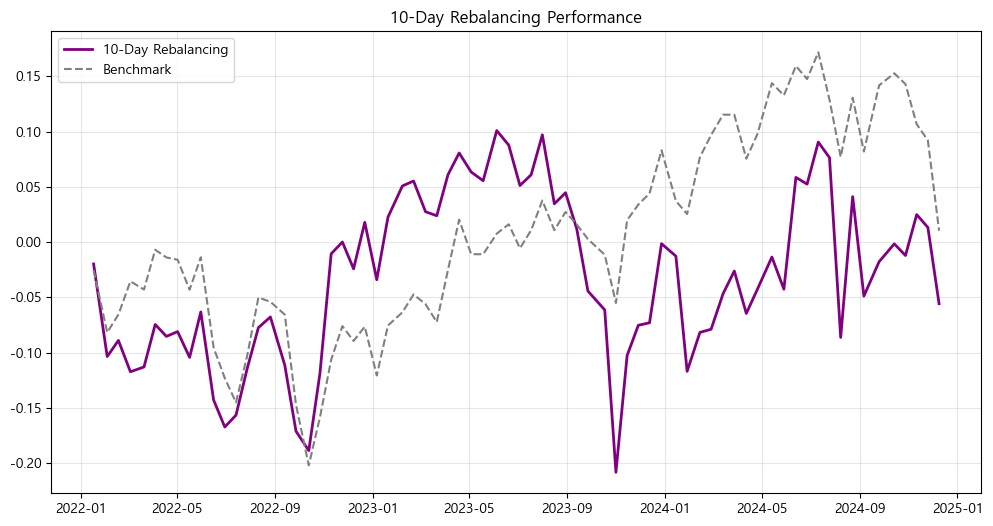

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------------------------------------
# 10일(2주) 단위 리밸런싱 백테스트 (수수료 0.2% 적용)
# -----------------------------------------------------------
print("\n백테스트 시뮬레이션 중 (10일 주기 Rebalancing)...")

# 전체 거래일 리스트
all_dates = sorted(test_copy['date'].unique())

# 10거래일 간격으로 리밸런싱 날짜 추출 (0, 10, 20, 30...)
rebal_dates = all_dates[::10] 

log_10d = []
cost = 0.002 # 수수료 0.2%

for i in range(len(rebal_dates) - 1):
    buy_date = rebal_dates[i]
    sell_date = rebal_dates[i+1] # 10일 뒤

    # 매수일 데이터
    day_data = test_copy[test_copy['date'] == buy_date]
    if len(day_data) < 20: continue

    # [Top 10] 예측 순위 높은 상위 10개
    # (아까 청개구리 현상 있었으면 ascending=True로, 아니면 False로 설정하세요)
    # 여기서는 정상적으로 '높은 점수가 좋다'고 가정 (False)
    top_10 = day_data.sort_values(by='pred_rank', ascending=False).head(10)['ticker'].tolist()
    
    # 수익률 계산 함수
    def calc_return(tickers, d1, d2):
        p1 = test_copy[(test_copy['date'] == d1) & (test_copy['ticker'].isin(tickers))].set_index('ticker')['종가']
        p2 = test_copy[(test_copy['date'] == d2) & (test_copy['ticker'].isin(tickers))].set_index('ticker')['종가']
        valid = p1.index.intersection(p2.index)
        if len(valid) == 0: return 0.0
        return ((p2[valid] / p1[valid]) - 1).mean()

    # 수익률 산출 (수수료 차감)
    r_top = calc_return(top_10, buy_date, sell_date) - cost
    r_bm = calc_return(day_data['ticker'].unique(), buy_date, sell_date) # 시장 평균

    log_10d.append({'date': sell_date, 'Strategy': r_top, 'Benchmark': r_bm})

# 결과 정리
res_10d = pd.DataFrame(log_10d).set_index('date')
cum_ret_10d = (1 + res_10d).cumprod() - 1

# 성과 출력
final_ret = cum_ret_10d.iloc[-1]
print(f"\n=== [10일 주기 리밸런싱] 최종 성과 (Cost 0.2%) ===")
print(f"AI Top 10 누적 수익률: {final_ret['Strategy']*100:.2f}%")
print(f"시장(BM) 누적 수익률 : {final_ret['Benchmark']*100:.2f}%")

# 그래프 비교
plt.figure(figsize=(12, 6))
plt.plot(cum_ret_10d.index, cum_ret_10d['Strategy'], label='10-Day Rebalancing', color='purple', linewidth=2)
plt.plot(cum_ret_10d.index, cum_ret_10d['Benchmark'], label='Benchmark', color='gray', linestyle='--')
plt.title('10-Day Rebalancing Performance')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

1. 데이터 병합 및 전처리 중...
2. Feature Engineering (Max 20일) 중...
Feature 생성 완료. 사용 컬럼 수: 13개

3. 데이터 분할 및 과적합 점검...
Dataset Shape - Train: (204203, 32), Val: (90981, 32), Test: (142061, 32)
----------------------------------------
[Train] IC (Rank Correlation): 0.1463
[Validation] IC (Rank Correlation): 0.0414
[Test (Real)] IC (Rank Correlation): 0.0254
----------------------------------------
ℹ️ 모델 성능이 낮습니다. Feature를 개선하거나 데이터를 확인하세요.

4. 10일 주기 리밸런싱 백테스트 수행 중...

5. 성과 분석 및 시각화...

=== 최종 성과 보고서 (10일 주기 리밸런싱, Cost 0.2%) ===
구분           | 누적수익률      | MDD        | Sharpe    
--------------------------------------------------
Top 10       |     -16.9% |     -28.8% |     -0.08
Bottom 10    |     -11.9% |     -28.8% |     -0.04
Benchmark    |       1.0% |     -19.7% |      0.11
--------------------------------------------------

[월별 수익률 (최근 5개월)]


C:\Users\rkdtk\AppData\Local\Temp\ipykernel_29204\1955363310.py:213: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = daily_ret_series.resample('M').apply(lambda x: (1+x).prod() -1)
C:\Users\rkdtk\AppData\Local\Temp\ipykernel_29204\1955363310.py:258: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(monthly_stats.tail(5).applymap(lambda x: f"{x*100:.2f}%"))


             Top10 Bottom10 Benchmark
date                                 
2024-08-31  -2.12%    9.29%     0.16%
2024-09-30  -6.21%   -4.06%     0.98%
2024-10-31  -1.66%    3.76%     0.10%
2024-11-30  -3.72%   -7.79%    -4.46%
2024-12-31  -8.78%   -4.99%    -7.48%


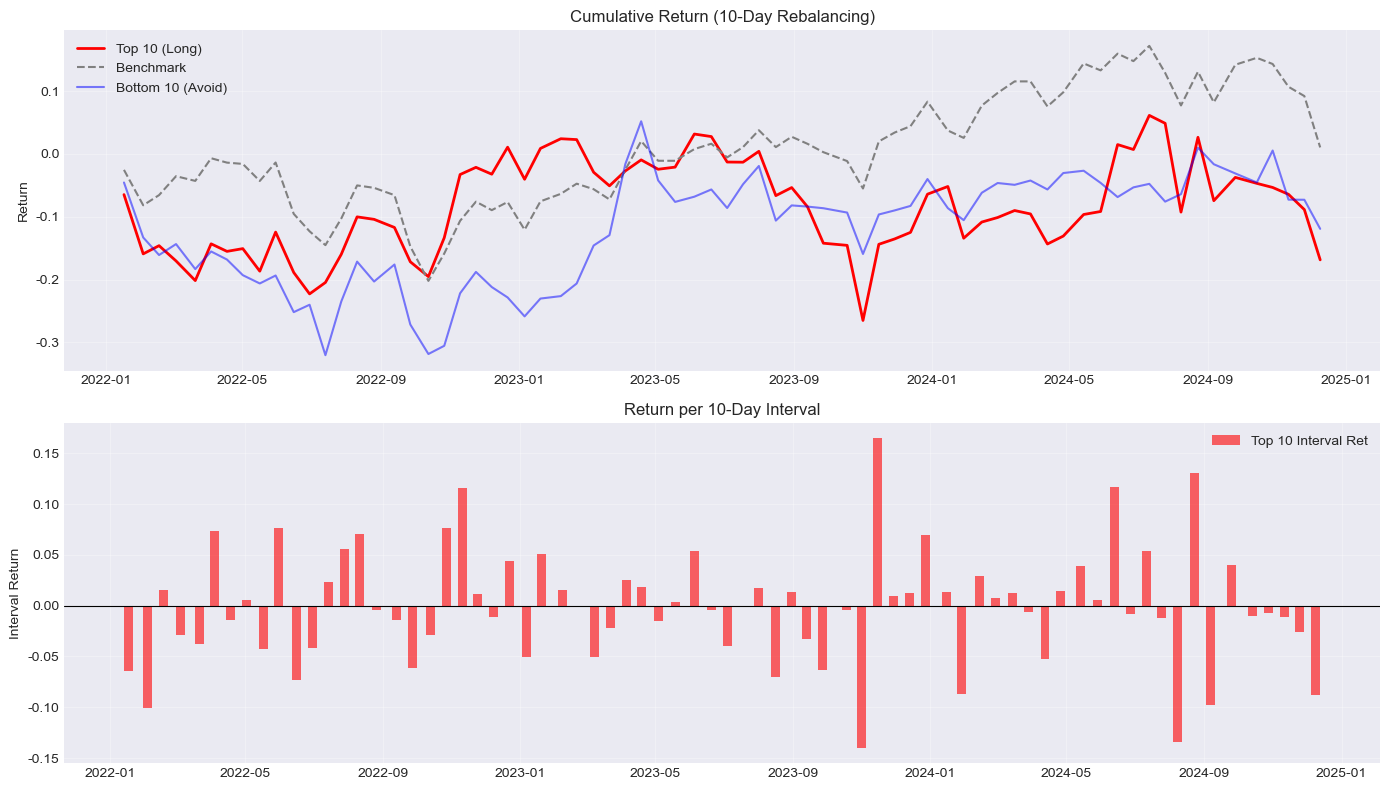

In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화 설정 (한글 폰트 등 환경에 맞게 조정 필요)
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('seaborn-v0_8-darkgrid')

# ==============================================================================
# 1. 데이터 병합 및 전처리 (데이터 누수 방지 기초)
# ==============================================================================
print("1. 데이터 병합 및 전처리 중...")

# df1, df2가 로드되어 있다고 가정 (없으면 예시 데이터 생성 필요)
# 날짜 변환 및 정렬 (시간 순서 중요)
df1['date'] = pd.to_datetime(df1['date'])
df2['date'] = pd.to_datetime(df2['date'])
df1['ticker'] = df1['ticker'].astype(str)
df2['ticker'] = df2['ticker'].astype(str)

# 병합 (Left Join: 가격 데이터 기준)
df = pd.merge(df1, df2, on=['date', 'ticker'], how='left')

# 수급 결측치 0 처리 (정보 부재 = 매수 없음)
investor_cols = [c for c in df.columns if '순매수' in c]
df[investor_cols] = df[investor_cols].fillna(0)

# [중요] 날짜/종목 정렬 (이동평균 계산 시 필수)
df = df.sort_values(['ticker', 'date']).reset_index(drop=True)

# ==============================================================================
# 2. Feature Engineering (Max 20일 제한 -> 데이터 손실 최소화)
# ==============================================================================
print("2. Feature Engineering (Max 20일) 중...")

# (1) Target 생성: 10일 후 수익률의 '순위(Rank)' (0~1)
# shift(-10)은 미래 데이터이므로 Target 생성에만 사용 (Feature엔 절대 사용 금지)
df['fwd_ret_10d'] = df.groupby('ticker')['종가'].shift(-10) / df['종가'] - 1
df['target_rank'] = df.groupby('date')['fwd_ret_10d'].rank(pct=True)

# (2) Feature 생성 (과거 20일 이내 데이터만 사용)
# 추세 (이격도)
for w in [5, 20]:
    ma = df.groupby('ticker')['종가'].rolling(window=w).mean().reset_index(0, drop=True)
    df[f'disparity_{w}'] = df['종가'] / ma

# RSI (14일)
def calc_rsi(x, window=14):
    delta = x.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / (loss + 1e-9)
    return 100 - (100 / (1 + rs))
df['rsi_14'] = df.groupby('ticker')['종가'].transform(lambda x: calc_rsi(x))

# MACD
def calc_macd(x):
    exp12 = x.ewm(span=12, adjust=False).mean()
    exp26 = x.ewm(span=26, adjust=False).mean()
    return exp12 - exp26
df['macd'] = df.groupby('ticker')['종가'].transform(lambda x: calc_macd(x))

# 볼린저 밴드 %B (20일)
def calc_bb(x, window=20):
    ma = x.rolling(window=window).mean()
    std = x.rolling(window=window).std()
    upper = ma + (std * 2)
    lower = ma - (std * 2)
    return (x - lower) / (upper - lower + 1e-9)
df['bollinger_pb'] = df.groupby('ticker')['종가'].transform(lambda x: calc_bb(x))

# 변동성 (5일)
df['volatility_5'] = df.groupby('ticker')['등락률'].rolling(window=5).std().reset_index(0, drop=True)

# 수급 누적 (5일, 20일)
target_amount_col = '순매수_금액' if '외국인_순매수_금액' in df.columns else '순매수_수량'
for subj in ['외국인', '기관', '개인']:
    col = f'{subj}_{target_amount_col}'
    if col in df.columns:
        df[f'{col}_sum_5'] = df.groupby('ticker')[col].rolling(window=5).sum().reset_index(0, drop=True)
        df[f'{col}_sum_20'] = df.groupby('ticker')[col].rolling(window=20).sum().reset_index(0, drop=True)

# 거래량 회전율
v5 = df.groupby('ticker')['거래량'].rolling(window=5).mean().reset_index(0, drop=True)
v20 = df.groupby('ticker')['거래량'].rolling(window=20).mean().reset_index(0, drop=True)
df['volume_ratio'] = v5 / (v20 + 1e-9)

# (3) 데이터 정제
features = [c for c in df.columns if c not in ['date', 'ticker', 'fwd_ret_10d', 'target_rank'] + list(df1.columns) + list(df2.columns)]
# 위 자동 추출이 불안하면 직접 리스트 지정 추천:
features = [
    'disparity_5', 'disparity_20', 'rsi_14', 'macd', 'bollinger_pb', 'volatility_5', 'volume_ratio'
] + [c for c in df.columns if '_sum_' in c]

model_df = df.dropna(subset=features + ['target_rank']).copy()
print(f"Feature 생성 완료. 사용 컬럼 수: {len(features)}개")

# ==============================================================================
# 3. 데이터 분할 및 과적합 점검 (Train / Val / Test)
# ==============================================================================
print("\n3. 데이터 분할 및 과적합 점검...")

train = model_df[model_df['date'].between('2015-01-01', '2019-12-31')]
val   = model_df[model_df['date'].between('2020-01-01', '2021-12-31')]
test  = model_df[model_df['date'].between('2022-01-01', '2024-12-31')]

print(f"Dataset Shape - Train: {train.shape}, Val: {val.shape}, Test: {test.shape}")

# 모델 학습
model = XGBRegressor(
    n_estimators=1000, learning_rate=0.01, max_depth=6,
    subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1,
    early_stopping_rounds=50
)

model.fit(
    train[features], train['target_rank'],
    eval_set=[(train[features], train['target_rank']), (val[features], val['target_rank'])],
    verbose=0
)

# [중요] 과적합 확인을 위한 IC(상관계수) 계산 함수
def get_ic(dataset, model, name):
    pred = model.predict(dataset[features])
    ic = pd.DataFrame({'actual': dataset['target_rank'], 'pred': pred}).corr(method='spearman').iloc[0, 1]
    print(f"[{name}] IC (Rank Correlation): {ic:.4f}")
    return ic

print("-" * 40)
train_ic = get_ic(train, model, "Train")
val_ic   = get_ic(val,   model, "Validation")
test_ic  = get_ic(test,  model, "Test (Real)")
print("-" * 40)

if train_ic > 0.5 and test_ic < 0.01:
    print("⚠️ 경고: 심각한 과적합(Overfitting)이 의심됩니다. 파라미터 튜닝이 필요합니다.")
elif test_ic > 0.03:
    print("✅ 모델 상태 양호: Test 데이터에서도 유의미한 예측력을 보입니다.")
else:
    print("ℹ️ 모델 성능이 낮습니다. Feature를 개선하거나 데이터를 확인하세요.")

# ==============================================================================
# 4. 10일 주기 리밸런싱 백테스트 (Top 10 vs Bottom 10)
# ==============================================================================
print("\n4. 10일 주기 리밸런싱 백테스트 수행 중...")

# Test 데이터 복사 및 예측
backtest_df = test.copy()
backtest_df['pred_rank'] = model.predict(backtest_df[features])

# 10거래일 간격 날짜 추출
all_dates = sorted(backtest_df['date'].unique())
rebal_dates = all_dates[::10]  # 0, 10, 20... 인덱스 날짜

log_10d = []
cost = 0.002  # 수수료 0.2%

for i in range(len(rebal_dates) - 1):
    buy_date = rebal_dates[i]
    sell_date = rebal_dates[i+1] # 10거래일 뒤
    
    # 1. 매수일(Buy Date) 데이터로 종목 선정 (Leakage 방지)
    day_data = backtest_df[backtest_df['date'] == buy_date]
    if len(day_data) < 20: continue # 데이터 부족 시 패스
    
    # Top 10 (Long): 점수 높은 순
    top_10 = day_data.sort_values(by='pred_rank', ascending=False).head(10)['ticker'].tolist()
    # Bottom 10 (Short/Avoid): 점수 낮은 순
    bottom_10 = day_data.sort_values(by='pred_rank', ascending=True).head(10)['ticker'].tolist()
    
    # 2. 수익률 계산: (매도일 종가 / 매수일 종가) - 1
    # 매수일 가격
    p_buy = backtest_df[backtest_df['date'] == buy_date].set_index('ticker')['종가']
    # 매도일 가격 (10일 뒤)
    p_sell = backtest_df[backtest_df['date'] == sell_date].set_index('ticker')['종가']
    
    def calc_group_ret(tickers):
        # 매수/매도일 모두 데이터가 있는 종목만 계산 (상폐/정지 방지)
        valid = [t for t in tickers if t in p_buy.index and t in p_sell.index]
        if not valid: return 0.0
        # 수익률 평균 - 수수료
        return ((p_sell[valid] / p_buy[valid]) - 1).mean() - cost

    # 벤치마크 (KOSPI 200 전체 - 수수료 제외)
    common_tickers = p_buy.index.intersection(p_sell.index)
    bm_ret = ((p_sell[common_tickers] / p_buy[common_tickers]) - 1).mean()

    log_10d.append({
        'date': sell_date, # 수익 실현일 기준 기록
        'Top10_Ret': calc_group_ret(top_10),
        'Bottom10_Ret': calc_group_ret(bottom_10),
        'Benchmark_Ret': bm_ret
    })

# 결과 DataFrame
res = pd.DataFrame(log_10d).set_index('date')
res.index = pd.to_datetime(res.index) # 인덱스 datetime 확실화

# ==============================================================================
# 5. 성과 지표 산출 (누적 수익률, MDD, Sharpe)
# ==============================================================================
print("\n5. 성과 분석 및 시각화...")

# (1) 누적 수익률 계산
cum_ret = (1 + res).cumprod() - 1

# (2) 월별 통계 산출 함수
def analyze_performance(daily_ret_series, period_str="Monthly"):
    # 월별로 리샘플링하여 합산 수익률 계산 (근사치)
    monthly = daily_ret_series.resample('M').apply(lambda x: (1+x).prod() -1)
    
    # 누적
    cum = (1 + daily_ret_series).cumprod()
    
    # MDD
    peak = cum.cummax()
    drawdown = (cum - peak) / peak
    mdd = drawdown.min()
    
    # Sharpe (10일 주기 데이터이므로 연율화 시 sqrt(25) 근사)
    # 1년 = 약 250거래일, 10일 주기 = 연 25회
    sharpe = (daily_ret_series.mean() / daily_ret_series.std()) * np.sqrt(25)
    
    # 최종 수익률
    total_ret = cum.iloc[-1] - 1
    
    return total_ret, mdd, sharpe, monthly

# Top 10 분석
top_total, top_mdd, top_sharpe, top_monthly = analyze_performance(res['Top10_Ret'])
# Bottom 10 분석
bot_total, bot_mdd, bot_sharpe, bot_monthly = analyze_performance(res['Bottom10_Ret'])
# BM 분석
bm_total, bm_mdd, bm_sharpe, bm_monthly = analyze_performance(res['Benchmark_Ret'])

# 결과 출력
print(f"\n=== 최종 성과 보고서 (10일 주기 리밸런싱, Cost 0.2%) ===")
print(f"{'구분':<12} | {'누적수익률':<10} | {'MDD':<10} | {'Sharpe':<10}")
print("-" * 50)
print(f"{'Top 10':<12} | {top_total*100:>9.1f}% | {top_mdd*100:>9.1f}% | {top_sharpe:>9.2f}")
print(f"{'Bottom 10':<12} | {bot_total*100:>9.1f}% | {bot_mdd*100:>9.1f}% | {bot_sharpe:>9.2f}")
print(f"{'Benchmark':<12} | {bm_total*100:>9.1f}% | {bm_mdd*100:>9.1f}% | {bm_sharpe:>9.2f}")
print("-" * 50)

# ==============================================================================
# 6. 월별 누적 수익률 테이블 및 시각화
# ==============================================================================
# 월별 수익률 테이블 만들기
monthly_stats = pd.DataFrame({
    'Top10': top_monthly,
    'Bottom10': bot_monthly,
    'Benchmark': bm_monthly
})
print("\n[월별 수익률 (최근 5개월)]")
print(monthly_stats.tail(5).applymap(lambda x: f"{x*100:.2f}%"))

# 그래프 그리기
plt.figure(figsize=(14, 8))

# 1. 누적 수익률 그래프
plt.subplot(2, 1, 1)
plt.plot(cum_ret.index, cum_ret['Top10_Ret'], label='Top 10 (Long)', color='red', linewidth=2)
plt.plot(cum_ret.index, cum_ret['Benchmark_Ret'], label='Benchmark', color='gray', linestyle='--')
plt.plot(cum_ret.index, cum_ret['Bottom10_Ret'], label='Bottom 10 (Avoid)', color='blue', alpha=0.5)
plt.title('Cumulative Return (10-Day Rebalancing)')
plt.ylabel('Return')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. 리밸런싱 구간별(10일) 수익률 분포
plt.subplot(2, 1, 2)
plt.bar(res.index, res['Top10_Ret'], width=8, label='Top 10 Interval Ret', color='red', alpha=0.6)
plt.axhline(0, color='black', linewidth=0.8)
plt.title('Return per 10-Day Interval')
plt.ylabel('Interval Return')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [4]:
# ==============================================================================
# 4. 10일 주기 리밸런싱 백테스트 + [매매 기록 기능 추가]
# ==============================================================================
print("\n4. 10일 주기 리밸런싱 및 매매 내역 기록 중...")

# Test 데이터 복사 및 예측
backtest_df = test.copy()
backtest_df['pred_rank'] = model.predict(backtest_df[features])

# 10거래일 간격 날짜 추출
all_dates = sorted(backtest_df['date'].unique())
rebal_dates = all_dates[::10]

log_10d = []
trade_logs = []  # [추가] 매매 기록을 저장할 리스트
prev_top_10 = [] # [추가] 이전 리밸런싱 때 샀던 종목들 (매도 대상)

cost = 0.002  # 수수료 0.2%

for i in range(len(rebal_dates) - 1):
    buy_date = rebal_dates[i]
    sell_date = rebal_dates[i+1] # 10거래일 뒤
    
    # 1. 종목 선정
    day_data = backtest_df[backtest_df['date'] == buy_date]
    if len(day_data) < 20: continue 
    
    # 이번 회차 매수 대상 (Top 10)
    current_top_10 = day_data.sort_values(by='pred_rank', ascending=False).head(10)['ticker'].tolist()
    
    # 2. 매매 기록 저장 (Log)
    # 매도 종목: 지난번에 샀던 종목들 (prev_top_10)
    # 매수 종목: 이번에 새로 사는 종목들 (current_top_10)
    # (교체 매매가 일어난 것만 보고 싶으면 집합(set) 연산으로 겹치는 것 제외 가능하나, 
    #  여기서는 포트폴리오 전체 교체를 가정하고 전체 리스트를 보여줍니다.)
    
    if len(current_top_10) > 0:
        trade_logs.append({
            '날짜': buy_date,
            '매도_종목(Previous)': prev_top_10 if prev_top_10 else ["신규 진입 (매도 없음)"],
            '매수_종목(New)': current_top_10
        })
    
    # 3. 수익률 계산 (기존 로직과 동일)
    # Top 10 수익률
    p_buy = backtest_df[backtest_df['date'] == buy_date].set_index('ticker')['종가']
    p_sell = backtest_df[backtest_df['date'] == sell_date].set_index('ticker')['종가']
    
    def calc_group_ret(tickers):
        valid = [t for t in tickers if t in p_buy.index and t in p_sell.index]
        if not valid: return 0.0
        return ((p_sell[valid] / p_buy[valid]) - 1).mean() - cost

    # 하위 10개 및 벤치마크 계산
    bottom_10 = day_data.sort_values(by='pred_rank', ascending=True).head(10)['ticker'].tolist()
    r_top = calc_group_ret(current_top_10)
    r_bottom = calc_group_ret(bottom_10)
    
    # 벤치마크 (KOSPI 200 전체)
    common_tickers = p_buy.index.intersection(p_sell.index)
    bm_ret = ((p_sell[common_tickers] / p_buy[common_tickers]) - 1).mean()

    log_10d.append({
        'date': sell_date,
        'Top10_Ret': r_top,
        'Bottom10_Ret': r_bottom,
        'Benchmark_Ret': bm_ret
    })
    
    # [중요] 다음 턴을 위해 현재 포트폴리오를 '이전 포트폴리오'로 저장
    prev_top_10 = current_top_10

# 결과 정리
res = pd.DataFrame(log_10d).set_index('date')
trade_df = pd.DataFrame(trade_logs) # 매매 기록 데이터프레임

# ==============================================================================
# 결과 출력: 매매 내역 확인
# ==============================================================================
print("\n=== 📋 리밸런싱 매매 내역 (최근 5회) ===")
# 보기 좋게 출력하기 위해 리스트를 문자열로 변환할 수도 있습니다.
pd.set_option('display.max_colwidth', 100) # 컬럼 내용 다 보이게 설정
display(trade_df.tail(5))

# 특정 날짜의 매매 내역을 자세히 보고 싶다면?
# 예: trade_df[trade_df['날짜'] == '2024-01-02']


4. 10일 주기 리밸런싱 및 매매 내역 기록 중...

=== 📋 리밸런싱 매매 내역 (최근 5회) ===


,날짜,매도_종목(Previous),매수_종목(New)
67,2024-09-25,"[005930, 042700, 000660, 097950, 000270, 207940, 003230, 004370, 298050, 138040]","[373220, 005490, 006400, 004370, 097950, 005930, 047050, 241560, 068270, 086790]"
68,2024-10-14,"[373220, 005490, 006400, 004370, 097950, 005930, 047050, 241560, 068270, 086790]","[207940, 011170, 004990, 018880, 090430, 005850, 051910, 000080, 001800, 161390]"
69,2024-10-28,"[207940, 011170, 004990, 018880, 090430, 005850, 051910, 000080, 001800, 161390]","[005380, 005930, 002380, 011070, 097950, 081660, 090430, 012450, 010140, 004990]"
70,2024-11-11,"[005380, 005930, 002380, 011070, 097950, 081660, 090430, 012450, 010140, 004990]","[010130, 006400, 005930, 005490, 456040, 011070, 145720, 005070, 097950, 003490]"
71,2024-11-25,"[010130, 006400, 005930, 005490, 456040, 011070, 145720, 005070, 097950, 003490]","[005490, 128940, 051910, 207940, 006400, 090430, 373220, 011780, 138040, 003230]"


In [5]:
import pandas as pd

# 1. 보기 좋게 포맷팅 (리스트 [...] 형태를 문자열 "종목A, 종목B"로 변환)
# trade_df가 이미 메모리에 있어야 합니다. (이전 코드 실행 후)
formatted_df = trade_df.copy()

def list_to_string(x):
    if isinstance(x, list):
        return ', '.join(x) # [A, B] -> "A, B"
    return x

formatted_df['매도_종목(Previous)'] = formatted_df['매도_종목(Previous)'].apply(list_to_string)
formatted_df['매수_종목(New)'] = formatted_df['매수_종목(New)'].apply(list_to_string)

# 2. Pandas 출력 옵션 설정 (모든 행과 긴 내용을 다 보여주기)
pd.set_option('display.max_rows', None)      # 행 개수 제한 해제 (전체 출력)
pd.set_option('display.max_colwidth', None)  # 컬럼 너비 제한 해제 (종목명 잘림 방지)
pd.set_option('display.width', 1000)         # 가로 폭 넓게

# 3. 전체 출력
print(f"\n=== 전체 리밸런싱 매매 내역 (총 {len(formatted_df)}회) ===")
display(formatted_df)

# 4. (추천) 엑셀로 보기 위해 CSV 저장
# 코랩이나 주피터 노트북의 파일 탐색기에서 다운로드 가능합니다.
filename = "AI_Rebalancing_Log.csv"
formatted_df.to_csv(filename, encoding='utf-8-sig', index=False)
print(f"\n💾 전체 내역이 '{filename}' 파일로 저장되었습니다.")

# 5. 설정 원상복구 (너무 길게 출력되는 것 방지)
pd.reset_option('display.max_rows')
pd.reset_option('display.max_colwidth')
pd.reset_option('display.width')


=== 전체 리밸런싱 매매 내역 (총 72회) ===


,날짜,매도_종목(Previous),매수_종목(New)
0,2022-01-03,신규 진입 (매도 없음),"051900, 035420, 298050, 298020, 259960, 036570, 051910, 010060, 097950, 280360"
1,2022-01-17,"051900, 035420, 298050, 298020, 259960, 036570, 051910, 010060, 097950, 280360","207940, 035720, 323410, 006400, 298050, 036570, 035420, 302440, 298020, 051900"
2,2022-02-03,"207940, 035720, 323410, 006400, 298050, 036570, 035420, 302440, 298020, 051900","035720, 051900, 298050, 361610, 006400, 036570, 005930, 068270, 066970, 005380"
3,2022-02-17,"035720, 051900, 298050, 361610, 006400, 036570, 005930, 068270, 066970, 005380","207940, 051910, 138040, 035420, 006400, 055550, 298020, 005380, 002380, 096770"
4,2022-03-04,"207940, 051910, 138040, 035420, 006400, 055550, 298020, 005380, 002380, 096770","051910, 006400, 005930, 036570, 005380, 000270, 051900, 302440, 259960, 373220"
5,2022-03-21,"051910, 006400, 005930, 036570, 005380, 000270, 051900, 302440, 259960, 373220","005930, 000270, 012330, 090430, 259960, 036570, 006400, 005380, 051900, 138040"
6,2022-04-04,"005930, 000270, 012330, 090430, 259960, 036570, 006400, 005380, 051900, 138040","005930, 000660, 068270, 051900, 008770, 204320, 014680, 000270, 055550, 001740"
7,2022-04-18,"005930, 000660, 068270, 051900, 008770, 204320, 014680, 000270, 055550, 001740","035420, 000660, 005930, 018260, 066970, 068270, 007310, 036570, 055550, 298020"
8,2022-05-02,"035420, 000660, 005930, 018260, 066970, 068270, 007310, 036570, 055550, 298020","035720, 035420, 259960, 352820, 036570, 006400, 011070, 000660, 302440, 298020"
9,2022-05-17,"035720, 035420, 259960, 352820, 036570, 006400, 011070, 000660, 302440, 298020","035420, 207940, 011070, 035720, 005380, 051900, 271560, 373220, 259960, 051910"



💾 전체 내역이 'AI_Rebalancing_Log.csv' 파일로 저장되었습니다.


In [6]:
from sklearn.metrics import mean_squared_error
import numpy as np

# ------------------------------------------------------------------------------
# 1. 성능 지표 계산 준비
# ------------------------------------------------------------------------------
# Test 데이터에 예측값(pred_rank)이 이미 있다고 가정 (앞선 코드 실행 후)
# 만약 없다면 아래 주석 해제하여 예측 실행
# backtest_df = test.copy()
# backtest_df['pred_rank'] = model.predict(backtest_df[features])

print(">>> 모델 성능 정밀 진단 중...\n")

# ------------------------------------------------------------------------------
# 2. Metric 1: Correlation (상관계수)
# ------------------------------------------------------------------------------
# (1) Pearson: 선형 상관관계 (값의 크기가 비례하는가?)
pearson_corr = backtest_df[['target_rank', 'pred_rank']].corr(method='pearson').iloc[0, 1]

# (2) Spearman (Test Corr): 순위 상관관계 (등수가 일치하는가?) -> IC(Information Coefficient)
spearman_corr = backtest_df[['target_rank', 'pred_rank']].corr(method='spearman').iloc[0, 1]

# ------------------------------------------------------------------------------
# 3. Metric 2: RMSE (Root Mean Squared Error)
# ------------------------------------------------------------------------------
# 0.0 ~ 1.0 사이의 Rank 값에 대한 오차입니다.
mse = mean_squared_error(backtest_df['target_rank'], backtest_df['pred_rank'])
rmse = np.sqrt(mse)

# ------------------------------------------------------------------------------
# 4. Metric 3: Hit Ratio (Top 10 적중률)
# ------------------------------------------------------------------------------
# 정의: AI가 뽑은 'Top 10' 종목 중, 실제로 수익률 상위 10%(또는 Top 10)에 든 비율
# 매일매일 계산해서 평균을 냅니다.

daily_hit_ratios = []
dates = backtest_df['date'].unique()

for d in dates:
    day_data = backtest_df[backtest_df['date'] == d]
    
    if len(day_data) < 20: continue # 데이터 부족 시 패스
    
    # AI 예측 Top 10 (종목코드 set)
    pred_top10 = set(day_data.sort_values(by='pred_rank', ascending=False).head(10)['ticker'])
    
    # 실제 정답 Top 10 (종목코드 set)
    actual_top10 = set(day_data.sort_values(by='target_rank', ascending=False).head(10)['ticker'])
    
    # 교집합 개수 (맞춘 개수)
    hits = len(pred_top10.intersection(actual_top10))
    
    # 적중률 (10개 중 몇 개 맞췄나)
    daily_hit_ratios.append(hits / 10.0)

avg_hit_ratio = np.mean(daily_hit_ratios)

# ------------------------------------------------------------------------------
# 5. 결과 리포트 출력
# ------------------------------------------------------------------------------
print("=" * 40)
print(f"   AI 모델 예측 성능 지표 (Test Set)")
print("=" * 40)
print(f"1. Pearson 상관계수 : {pearson_corr:.4f}")
print(f"   (예측값과 실제값의 선형적 일치도)")
print("-" * 40)
print(f"2. Test RMSE        : {rmse:.4f}")
print(f"   (순위 예측 오차, 낮을수록 좋음. 랜덤=약 0.29)")
print("-" * 40)
print(f"3. Test HitRatio    : {avg_hit_ratio*100:.2f}%")
print(f"   (Top 10 종목 선정 시 실제 Top 10 적중률)")
print("-" * 40)
print(f"4. Test Corr (IC)   : {spearman_corr:.4f}")
print(f"   (★핵심★ 순위 상관계수. 0.05 이상이면 우수)")
print("=" * 40)

# (참고) Hit Ratio 해석
if avg_hit_ratio > 0.1:
    print("\n💡 해석: 랜덤으로 찍으면 적중률은 약 5%(200개 중 10개)입니다.")
    print(f"   현재 모델은 {avg_hit_ratio/0.05:.1f}배 더 잘 맞추고 있습니다.")

>>> 모델 성능 정밀 진단 중...

   AI 모델 예측 성능 지표 (Test Set)
1. Pearson 상관계수 : 0.0173
   (예측값과 실제값의 선형적 일치도)
----------------------------------------
2. Test RMSE        : 0.2885
   (순위 예측 오차, 낮을수록 좋음. 랜덤=약 0.29)
----------------------------------------
3. Test HitRatio    : 4.90%
   (Top 10 종목 선정 시 실제 Top 10 적중률)
----------------------------------------
4. Test Corr (IC)   : 0.0254
   (★핵심★ 순위 상관계수. 0.05 이상이면 우수)


In [7]:
import pandas as pd
import numpy as np

# ------------------------------------------------------------------------------
# 1. 상승/하락 적중률 계산기
# ------------------------------------------------------------------------------
def calc_directional_accuracy(df, model, features, dates):
    print(f"📊 방향성 예측 정확도 분석 중... (총 {len(dates)-1}회 리밸런싱)")
    
    up_correct_count = 0   # 상승 예측했는데 진짜 오른 횟수 (Top 10)
    down_correct_count = 0 # 하락 예측했는데 진짜 내린 횟수 (Bottom 10)
    total_picks = 0        # 전체 종목 수 누적
    
    # 통계 저장을 위한 리스트
    log_acc = []

    for i in range(len(dates) - 1):
        buy_date = dates[i]
        sell_date = dates[i+1] # 10거래일 뒤
        
        # 1. 데이터 추출
        day_data = df[df['date'] == buy_date].copy()
        if len(day_data) < 20: continue
        
        # 예측 점수 생성
        day_data['pred_rank'] = model.predict(day_data[features])
        
        # 2. 실제 수익률 계산 (미래 10일 수익률)
        # (주의: 앞서 만든 'target_10d'나 'fwd_ret_10d'가 있으면 그거 써도 됨. 여기선 직접 계산)
        p_buy = df[df['date'] == buy_date].set_index('ticker')['종가']
        p_sell = df[df['date'] == sell_date].set_index('ticker')['종가']
        
        # 공통 종목 찾기
        valid_tickers = p_buy.index.intersection(p_sell.index)
        real_ret = (p_sell[valid_tickers] / p_buy[valid_tickers]) - 1
        
        # 데이터프레임에 실제 수익률 매핑
        day_data = day_data[day_data['ticker'].isin(valid_tickers)]
        day_data['real_return'] = day_data['ticker'].map(real_ret)
        
        # ----------------------------------------------------------------------
        # 3. 그룹별 적중률 계산
        # ----------------------------------------------------------------------
        # [Case 1: 점수 높은 그룹] AI가 "오른다"고 예측 (Top 10)
        top_group = day_data.sort_values(by='pred_rank', ascending=False).head(10)
        
        # [Case 2: 점수 낮은 그룹] AI가 "내린다"고 예측 (Bottom 10)
        bottom_group = day_data.sort_values(by='pred_rank', ascending=True).head(10)
        
        # 실제 결과 확인
        # Top 10 중 실제로 수익률 > 0 인 개수
        n_up_correct = (top_group['real_return'] > 0).sum()
        
        # Bottom 10 중 실제로 수익률 < 0 인 개수
        n_down_correct = (bottom_group['real_return'] < 0).sum()
        
        # 누적
        up_correct_count += n_up_correct
        down_correct_count += n_down_correct
        total_picks += 10 # 매번 10개씩 뽑음
        
        log_acc.append({
            'date': buy_date,
            'Top10_WinRate': n_up_correct / 10.0,      # 이번 턴의 상승 적중률
            'Bottom10_LossRate': n_down_correct / 10.0 # 이번 턴의 하락 적중률
        })

    # --------------------------------------------------------------------------
    # 4. 최종 결과 출력
    # --------------------------------------------------------------------------
    avg_up_acc = (up_correct_count / total_picks) * 100
    avg_down_acc = (down_correct_count / total_picks) * 100
    
    print("\n" + "="*50)
    print(f"🎯 AI 방향성 예측 적중률 (Directional Accuracy)")
    print("="*50)
    
    print(f"1. [상승 예측] 점수 높은 Top 10을 샀을 때:")
    print(f"   👉 실제로 오를 확률 (Win Rate): {avg_up_acc:.2f}%")
    
    print(f"\n2. [하락 예측] 점수 낮은 Bottom 10을 공매도했을 때:")
    print(f"   👉 실제로 내릴 확률 (Hit Rate): {avg_down_acc:.2f}%")
    print("-" * 50)
    
    # 청개구리 여부 판독
    if avg_up_acc < 50 and avg_down_acc < 50:
        print("🚨 [진단] 모델이 반대로 예측하고 있습니다! (청개구리)")
        print("   -> 점수 낮은 놈을 매수하고(Long), 높은 놈을 공매도(Short)하세요.")
    elif avg_up_acc > 50:
        print("✅ [진단] 모델이 정상적으로 작동 중입니다.")
        print("   -> 점수 높은 놈을 매수(Long)하세요.")

    return pd.DataFrame(log_acc)

# 실행 (rebal_dates는 이전 코드에서 생성된 10일 주기 날짜 리스트)
acc_df = calc_directional_accuracy(backtest_df, model, features, rebal_dates)

# 최근 5회 적중률 확인
print("\n[최근 5회 리밸런싱 적중률]")
display(acc_df.tail(5).style.format("{:.0%}"))

📊 방향성 예측 정확도 분석 중... (총 72회 리밸런싱)

🎯 AI 방향성 예측 적중률 (Directional Accuracy)
1. [상승 예측] 점수 높은 Top 10을 샀을 때:
   👉 실제로 오를 확률 (Win Rate): 49.17%

2. [하락 예측] 점수 낮은 Bottom 10을 공매도했을 때:
   👉 실제로 내릴 확률 (Hit Rate): 54.17%
--------------------------------------------------

[최근 5회 리밸런싱 적중률]


ValueError: Invalid format string

🚀 1. 데이터 병합 및 전처리 중...
🚀 2. Feature Engineering (데이터 손실 최소화) 중...

🚀 3. 모델 학습 및 과적합 점검...
[Train] IC: 0.1463
[Test] IC: 0.0254

🚀 4. 10일 주기 리밸런싱 백테스트 수행 중...
💾 매매 내역이 'Trade_Logs_10Day.csv'로 저장되었습니다.

 최종 성과 보고서 (10일 주기, Cost 0.2%)
지표           | Top 10     | Bottom 10  | Benchmark 
--------------------------------------------------
누적수익         |     -16.9% |     -11.9% |       1.0%
MDD          |     -28.8% |     -28.8% |     -19.7%
Sharpe       |     -0.08  |     -0.04  |      0.11

📊 방향성 및 적중률 분석 중...
 - Top 10 상승 적중률: 49.17%
 - Bottom 10 하락 적중률: 54.17%

[최근 5회 적중률]


,date,WinRate_Top10,LossRate_Bot10
67,2024-09-25 00:00:00,30%,70%
68,2024-10-14 00:00:00,40%,50%
69,2024-10-28 00:00:00,20%,80%
70,2024-11-11 00:00:00,60%,40%
71,2024-11-25 00:00:00,10%,80%


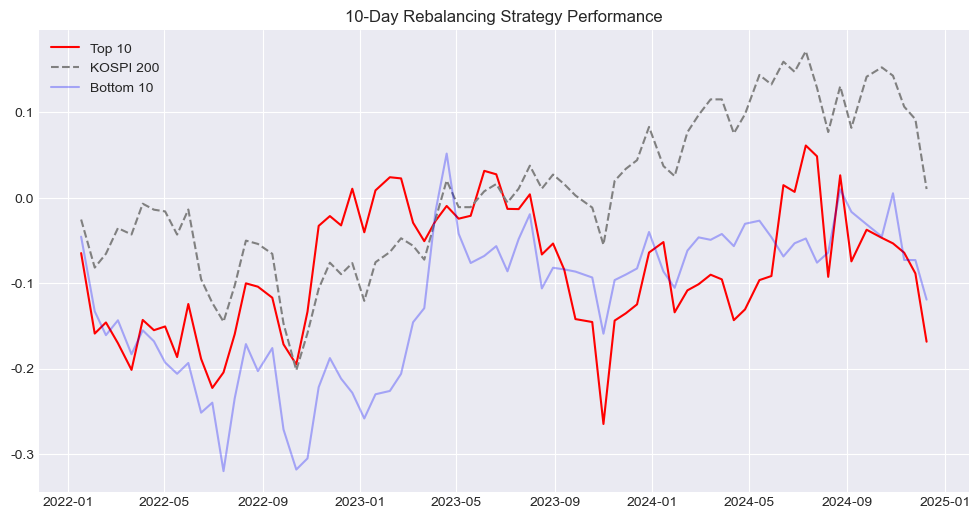

In [8]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화 설정
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('seaborn-v0_8-darkgrid')

# ==============================================================================
# 1. 데이터 병합 및 전처리
# ==============================================================================
print("🚀 1. 데이터 병합 및 전처리 중...")

# (가정) df1, df2가 이미 로드되어 있다고 가정합니다.
# 날짜 포맷 통일
df1['date'] = pd.to_datetime(df1['date'])
df2['date'] = pd.to_datetime(df2['date'])
df1['ticker'] = df1['ticker'].astype(str)
df2['ticker'] = df2['ticker'].astype(str)

# 병합
df = pd.merge(df1, df2, on=['date', 'ticker'], how='left')

# 수급 결측치 처리
inv_cols = [c for c in df.columns if '순매수' in c]
df[inv_cols] = df[inv_cols].fillna(0)

# 정렬 (필수)
df = df.sort_values(['ticker', 'date']).reset_index(drop=True)

# ==============================================================================
# 2. Feature Engineering (Max 20일 제한)
# ==============================================================================
print("🚀 2. Feature Engineering (데이터 손실 최소화) 중...")

# (1) Target 생성: 10일 후 수익률의 순위 (0~1)
df['fwd_ret_10d'] = df.groupby('ticker')['종가'].shift(-10) / df['종가'] - 1
df['target_rank'] = df.groupby('date')['fwd_ret_10d'].rank(pct=True)

# (2) Feature 생성
# 이격도 (5, 20일)
for w in [5, 20]:
    ma = df.groupby('ticker')['종가'].rolling(window=w).mean().reset_index(0, drop=True)
    df[f'disparity_{w}'] = df['종가'] / ma

# RSI (14일)
def calc_rsi(x, window=14):
    delta = x.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / (loss + 1e-9)
    return 100 - (100 / (1 + rs))
df['rsi_14'] = df.groupby('ticker')['종가'].transform(lambda x: calc_rsi(x))

# MACD
def calc_macd(x):
    e12 = x.ewm(span=12, adjust=False).mean()
    e26 = x.ewm(span=26, adjust=False).mean()
    return e12 - e26
df['macd'] = df.groupby('ticker')['종가'].transform(lambda x: calc_macd(x))

# 볼린저 밴드 %B
def calc_bb(x, w=20):
    ma = x.rolling(w).mean()
    std = x.rolling(w).std()
    upper = ma + 2*std
    lower = ma - 2*std
    return (x - lower) / (upper - lower + 1e-9)
df['bollinger_pb'] = df.groupby('ticker')['종가'].transform(lambda x: calc_bb(x))

# 변동성, 거래량비율, 수급 누적
df['volatility_5'] = df.groupby('ticker')['등락률'].rolling(5).std().reset_index(0, drop=True)

v5 = df.groupby('ticker')['거래량'].rolling(5).mean().reset_index(0, drop=True)
v20 = df.groupby('ticker')['거래량'].rolling(20).mean().reset_index(0, drop=True)
df['volume_ratio'] = v5 / (v20 + 1e-9)

target_amt = '순매수_금액' if '외국인_순매수_금액' in df.columns else '순매수_수량'
for subj in ['외국인', '기관', '개인']:
    col = f'{subj}_{target_amt}'
    if col in df.columns:
        df[f'{col}_sum_5'] = df.groupby('ticker')[col].rolling(5).sum().reset_index(0, drop=True)
        df[f'{col}_sum_20'] = df.groupby('ticker')[col].rolling(20).sum().reset_index(0, drop=True)

# Feature 선택 (누수 방지용 필터링)
features = [
    'disparity_5', 'disparity_20', 'rsi_14', 'macd', 'bollinger_pb', 
    'volatility_5', 'volume_ratio'
] + [c for c in df.columns if '_sum_' in c]

# 결측치 제거
model_df = df.dropna(subset=features + ['target_rank']).copy()

# ==============================================================================
# 3. 데이터 분할 및 모델 학습
# ==============================================================================
print("\n🚀 3. 모델 학습 및 과적합 점검...")

train = model_df[model_df['date'].between('2015-01-01', '2019-12-31')]
val   = model_df[model_df['date'].between('2020-01-01', '2021-12-31')]
test  = model_df[model_df['date'].between('2022-01-01', '2024-12-31')]

model = XGBRegressor(
    n_estimators=1000, learning_rate=0.01, max_depth=6,
    subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1,
    early_stopping_rounds=50
)

model.fit(
    train[features], train['target_rank'],
    eval_set=[(train[features], train['target_rank']), (val[features], val['target_rank'])],
    verbose=0
)

# IC 확인
def get_ic(ds, name):
    pred = model.predict(ds[features])
    ic = pd.DataFrame({'act': ds['target_rank'], 'pred': pred}).corr(method='spearman').iloc[0, 1]
    print(f"[{name}] IC: {ic:.4f}")
    return ic

train_ic = get_ic(train, "Train")
test_ic = get_ic(test, "Test")

# ==============================================================================
# 4. 10일 주기 리밸런싱 백테스트 (매매기록 포함)
# ==============================================================================
print("\n🚀 4. 10일 주기 리밸런싱 백테스트 수행 중...")

backtest_df = test.copy()
backtest_df['pred_rank'] = model.predict(backtest_df[features])

all_dates = sorted(backtest_df['date'].unique())
rebal_dates = all_dates[::10]  # 10일 간격

log_10d = []
trade_logs = []
cost = 0.002

for i in range(len(rebal_dates) - 1):
    buy_date = rebal_dates[i]
    sell_date = rebal_dates[i+1]
    
    # 매수일 기준 종목 선정
    day_data = backtest_df[backtest_df['date'] == buy_date]
    if len(day_data) < 20: continue
    
    # Top 10 / Bottom 10 선정
    top_10 = day_data.sort_values(by='pred_rank', ascending=False).head(10)['ticker'].tolist()
    bottom_10 = day_data.sort_values(by='pred_rank', ascending=True).head(10)['ticker'].tolist()
    
    # 매매 기록 저장
    trade_logs.append({
        '날짜': buy_date,
        '매수(Top10)': ", ".join(top_10),
        '공매도(Bottom10)': ", ".join(bottom_10)
    })
    
    # 수익률 계산 (매도일 종가 / 매수일 종가)
    p_buy = backtest_df[backtest_df['date'] == buy_date].set_index('ticker')['종가']
    p_sell = backtest_df[backtest_df['date'] == sell_date].set_index('ticker')['종가']
    
    def calc_ret(tickers):
        valid = [t for t in tickers if t in p_buy.index and t in p_sell.index]
        if not valid: return 0.0
        return ((p_sell[valid] / p_buy[valid]) - 1).mean() - cost

    bm_ret = ((p_sell.loc[p_buy.index.intersection(p_sell.index)] / 
               p_buy.loc[p_buy.index.intersection(p_sell.index)]) - 1).mean()

    log_10d.append({
        'date': sell_date,
        'Top10': calc_ret(top_10),
        'Bottom10': calc_ret(bottom_10),
        'Benchmark': bm_ret
    })

res = pd.DataFrame(log_10d).set_index('date')
trade_df = pd.DataFrame(trade_logs)

# 매매 내역 CSV 저장
trade_df.to_csv("Trade_Logs_10Day.csv", encoding='utf-8-sig', index=False)
print("💾 매매 내역이 'Trade_Logs_10Day.csv'로 저장되었습니다.")

# ==============================================================================
# 5. 성과 지표 산출 (MDD, Sharpe, CAGR)
# ==============================================================================
def calc_metrics(series):
    cum = (1 + series).cumprod()
    total_ret = cum.iloc[-1] - 1
    # 10일 주기 = 연 약 25회
    cagr = (1 + total_ret) ** (25 / len(series)) - 1
    peak = cum.cummax()
    mdd = ((cum - peak) / peak).min()
    sharpe = (series.mean() / series.std()) * np.sqrt(25)
    return total_ret, cagr, mdd, sharpe

t_metrics = calc_metrics(res['Top10'])
b_metrics = calc_metrics(res['Bottom10'])
m_metrics = calc_metrics(res['Benchmark'])

print("\n" + "="*50)
print(f" 최종 성과 보고서 (10일 주기, Cost 0.2%)")
print("="*50)
print(f"{'지표':<12} | {'Top 10':<10} | {'Bottom 10':<10} | {'Benchmark':<10}")
print("-" * 50)
print(f"{'누적수익':<12} | {t_metrics[0]*100:>9.1f}% | {b_metrics[0]*100:>9.1f}% | {m_metrics[0]*100:>9.1f}%")
print(f"{'MDD':<12} | {t_metrics[2]*100:>9.1f}% | {b_metrics[2]*100:>9.1f}% | {m_metrics[2]*100:>9.1f}%")
print(f"{'Sharpe':<12} | {t_metrics[3]:>9.2f}  | {b_metrics[3]:>9.2f}  | {m_metrics[3]:>9.2f}")
print("=" * 50)

# ==============================================================================
# 6. 방향성 적중률 (Directional Accuracy) - [수정된 부분]
# ==============================================================================
print("\n📊 방향성 및 적중률 분석 중...")

da_logs = []
up_hits = 0
down_hits = 0
total_obs = 0

for i in range(len(rebal_dates) - 1):
    buy_date = rebal_dates[i]
    sell_date = rebal_dates[i+1]
    
    day_data = backtest_df[backtest_df['date'] == buy_date].copy()
    if len(day_data) < 20: continue
    
    # 실제 수익률 계산
    p_buy = backtest_df[backtest_df['date'] == buy_date].set_index('ticker')['종가']
    p_sell = backtest_df[backtest_df['date'] == sell_date].set_index('ticker')['종가']
    
    valid = p_buy.index.intersection(p_sell.index)
    real_ret = (p_sell[valid] / p_buy[valid]) - 1
    day_data['real_ret'] = day_data['ticker'].map(real_ret)
    
    # Top 10 (상승 예측) 확인
    top10 = day_data.sort_values(by='pred_rank', ascending=False).head(10)
    n_up = (top10['real_ret'] > 0).sum()
    
    # Bottom 10 (하락 예측) 확인
    bot10 = day_data.sort_values(by='pred_rank', ascending=True).head(10)
    n_down = (bot10['real_ret'] < 0).sum()
    
    up_hits += n_up
    down_hits += n_down
    total_obs += 10
    
    da_logs.append({
        'date': buy_date,
        'WinRate_Top10': n_up / 10.0,
        'LossRate_Bot10': n_down / 10.0
    })

acc_df = pd.DataFrame(da_logs)
print(f" - Top 10 상승 적중률: {(up_hits/total_obs)*100:.2f}%")
print(f" - Bottom 10 하락 적중률: {(down_hits/total_obs)*100:.2f}%")

# [수정] 오류가 났던 부분: 날짜 컬럼 제외하고 포맷팅 적용
print("\n[최근 5회 적중률]")
cols_to_format = ['WinRate_Top10', 'LossRate_Bot10']
display(acc_df.tail(5).style.format({c: '{:.0%}' for c in cols_to_format}))

# ==============================================================================
# 7. 그래프 시각화
# ==============================================================================
cum_ret = (1 + res).cumprod() - 1
plt.figure(figsize=(12, 6))
plt.plot(cum_ret.index, cum_ret['Top10'], label='Top 10', color='red')
plt.plot(cum_ret.index, cum_ret['Benchmark'], label='KOSPI 200', color='gray', linestyle='--')
plt.plot(cum_ret.index, cum_ret['Bottom10'], label='Bottom 10', color='blue', alpha=0.3)
plt.title('10-Day Rebalancing Strategy Performance')
plt.legend()
plt.show()

In [ ]:
# 수익률 0.00일때

🚀 1. 데이터 병합 및 전처리 중...
🚀 2. Feature Engineering (데이터 손실 최소화) 중...

🚀 3. 모델 학습 및 과적합 점검...
[Train] IC: 0.0752
[Test] IC: 0.0242

🚀 4. 10일 주기 리밸런싱 백테스트 수행 중...
💾 매매 내역이 'Trade_Logs_10Day.csv'로 저장되었습니다.

 최종 성과 보고서 (10일 주기, Cost 0.2%)
지표           | Top 10     | Bottom 10  | Benchmark 
--------------------------------------------------
누적수익         |      -5.9% |       0.5% |       1.0%
MDD          |     -30.4% |     -30.1% |     -19.7%
Sharpe       |      0.08  |      0.14  |      0.11

📊 방향성 및 적중률 분석 중...
 - Top 10 상승 적중률: 47.22%
 - Bottom 10 하락 적중률: 52.08%

[최근 5회 적중률]


,date,WinRate_Top10,LossRate_Bot10
67,2024-09-25 00:00:00,60%,60%
68,2024-10-14 00:00:00,30%,60%
69,2024-10-28 00:00:00,30%,80%
70,2024-11-11 00:00:00,60%,50%
71,2024-11-25 00:00:00,0%,90%


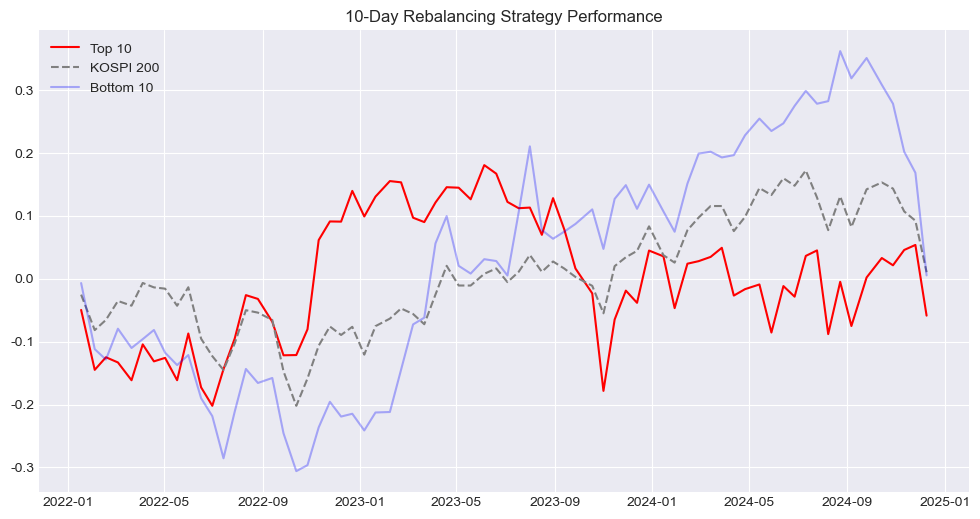

In [11]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화 설정
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('seaborn-v0_8-darkgrid')

# ==============================================================================
# 1. 데이터 병합 및 전처리
# ==============================================================================
print("🚀 1. 데이터 병합 및 전처리 중...")

# (가정) df1, df2가 이미 로드되어 있다고 가정합니다.
# 날짜 포맷 통일
df1['date'] = pd.to_datetime(df1['date'])
df2['date'] = pd.to_datetime(df2['date'])
df1['ticker'] = df1['ticker'].astype(str)
df2['ticker'] = df2['ticker'].astype(str)

# 병합
df = pd.merge(df1, df2, on=['date', 'ticker'], how='left')

# 수급 결측치 처리
inv_cols = [c for c in df.columns if '순매수' in c]
df[inv_cols] = df[inv_cols].fillna(0)

# 정렬 (필수)
df = df.sort_values(['ticker', 'date']).reset_index(drop=True)

# ==============================================================================
# 2. Feature Engineering (Max 20일 제한)
# ==============================================================================
print("🚀 2. Feature Engineering (데이터 손실 최소화) 중...")

# (1) Target 생성: 10일 후 수익률의 순위 (0~1)
df['fwd_ret_10d'] = df.groupby('ticker')['종가'].shift(-10) / df['종가'] - 1
df['target_rank'] = df.groupby('date')['fwd_ret_10d'].rank(pct=True)

# (2) Feature 생성
# 이격도 (5, 20일)
for w in [5, 20]:
    ma = df.groupby('ticker')['종가'].rolling(window=w).mean().reset_index(0, drop=True)
    df[f'disparity_{w}'] = df['종가'] / ma

# RSI (14일)
def calc_rsi(x, window=14):
    delta = x.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / (loss + 1e-9)
    return 100 - (100 / (1 + rs))
df['rsi_14'] = df.groupby('ticker')['종가'].transform(lambda x: calc_rsi(x))

# MACD
def calc_macd(x):
    e12 = x.ewm(span=12, adjust=False).mean()
    e26 = x.ewm(span=26, adjust=False).mean()
    return e12 - e26
df['macd'] = df.groupby('ticker')['종가'].transform(lambda x: calc_macd(x))

# 볼린저 밴드 %B
def calc_bb(x, w=20):
    ma = x.rolling(w).mean()
    std = x.rolling(w).std()
    upper = ma + 2*std
    lower = ma - 2*std
    return (x - lower) / (upper - lower + 1e-9)
df['bollinger_pb'] = df.groupby('ticker')['종가'].transform(lambda x: calc_bb(x))

# 변동성, 거래량비율, 수급 누적
df['volatility_5'] = df.groupby('ticker')['등락률'].rolling(5).std().reset_index(0, drop=True)

v5 = df.groupby('ticker')['거래량'].rolling(5).mean().reset_index(0, drop=True)
v20 = df.groupby('ticker')['거래량'].rolling(20).mean().reset_index(0, drop=True)
df['volume_ratio'] = v5 / (v20 + 1e-9)

target_amt = '순매수_금액' if '외국인_순매수_금액' in df.columns else '순매수_수량'
for subj in ['외국인', '기관', '개인']:
    col = f'{subj}_{target_amt}'
    if col in df.columns:
        df[f'{col}_sum_5'] = df.groupby('ticker')[col].rolling(5).sum().reset_index(0, drop=True)
        df[f'{col}_sum_20'] = df.groupby('ticker')[col].rolling(20).sum().reset_index(0, drop=True)

# Feature 선택 (누수 방지용 필터링)
features = [
    'disparity_5', 'disparity_20', 'rsi_14', 'macd', 'bollinger_pb', 
    'volatility_5', 'volume_ratio'
] + [c for c in df.columns if '_sum_' in c]

# 결측치 제거
model_df = df.dropna(subset=features + ['target_rank']).copy()

# ==============================================================================
# 3. 데이터 분할 및 모델 학습
# ==============================================================================
print("\n🚀 3. 모델 학습 및 과적합 점검...")

train = model_df[model_df['date'].between('2015-01-01', '2019-12-31')]
val   = model_df[model_df['date'].between('2020-01-01', '2021-12-31')]
test  = model_df[model_df['date'].between('2022-01-01', '2024-12-31')]

model = XGBRegressor(
    n_estimators=2000,      # 반복 횟수는 유지하되
    learning_rate=0.005,    # 학습 속도를 낮춰서 천천히 학습 (과적합 방지 핵심)
    
    # 1. 나무 깊이 제한 (가장 중요)
    max_depth=3,            # [수정] 6 -> 3 (나무를 얕게 만들어서 복잡한 패턴 무시)
    
    # 2. 잎사귀 제한
    min_child_weight=20,    # [수정] 한 그룹에 최소 20개 데이터는 있어야 함 (특이값 무시)
    
    # 3. 가지치기 (Pruning)
    gamma=0.3,              # [추가] 손실 감소가 0.3 이상일 때만 가지를 뻗음 (엄격하게)
    
    # 4. 무작위 샘플링 (다양성 확보)
    subsample=0.7,          # 데이터의 70%만 무작위 사용
    colsample_bytree=0.7,   # 컬럼의 70%만 무작위 사용
    
    # 5. 가중치 규제 (Regularization)
    reg_alpha=0.1,          # L1 규제 (불필요한 Feature 제거 효과)
    reg_lambda=1.0,         # L2 규제
    
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50
)

model.fit(
    train[features], train['target_rank'],
    eval_set=[(train[features], train['target_rank']), (val[features], val['target_rank'])],
    verbose=0
)

# IC 확인
def get_ic(ds, name):
    pred = model.predict(ds[features])
    ic = pd.DataFrame({'act': ds['target_rank'], 'pred': pred}).corr(method='spearman').iloc[0, 1]
    print(f"[{name}] IC: {ic:.4f}")
    return ic

train_ic = get_ic(train, "Train")
test_ic = get_ic(test, "Test")

# ==============================================================================
# 4. 10일 주기 리밸런싱 백테스트 (매매기록 포함)
# ==============================================================================
print("\n🚀 4. 10일 주기 리밸런싱 백테스트 수행 중...")

backtest_df = test.copy()
backtest_df['pred_rank'] = model.predict(backtest_df[features])

all_dates = sorted(backtest_df['date'].unique())
rebal_dates = all_dates[::10]  # 10일 간격

log_10d = []
trade_logs = []
cost = 0.00

for i in range(len(rebal_dates) - 1):
    buy_date = rebal_dates[i]
    sell_date = rebal_dates[i+1]
    
    # 매수일 기준 종목 선정
    day_data = backtest_df[backtest_df['date'] == buy_date]
    if len(day_data) < 20: continue
    
    # Top 10 / Bottom 10 선정
    top_10 = day_data.sort_values(by='pred_rank', ascending=False).head(10)['ticker'].tolist()
    bottom_10 = day_data.sort_values(by='pred_rank', ascending=True).head(10)['ticker'].tolist()
    
    # 매매 기록 저장
    trade_logs.append({
        '날짜': buy_date,
        '매수(Top10)': ", ".join(top_10),
        '공매도(Bottom10)': ", ".join(bottom_10)
    })
    
    # 수익률 계산 (매도일 종가 / 매수일 종가)
    p_buy = backtest_df[backtest_df['date'] == buy_date].set_index('ticker')['종가']
    p_sell = backtest_df[backtest_df['date'] == sell_date].set_index('ticker')['종가']
    
    def calc_ret(tickers):
        valid = [t for t in tickers if t in p_buy.index and t in p_sell.index]
        if not valid: return 0.0
        return ((p_sell[valid] / p_buy[valid]) - 1).mean() - cost

    bm_ret = ((p_sell.loc[p_buy.index.intersection(p_sell.index)] / 
               p_buy.loc[p_buy.index.intersection(p_sell.index)]) - 1).mean()

    log_10d.append({
        'date': sell_date,
        'Top10': calc_ret(top_10),
        'Bottom10': calc_ret(bottom_10),
        'Benchmark': bm_ret
    })

res = pd.DataFrame(log_10d).set_index('date')
trade_df = pd.DataFrame(trade_logs)

# 매매 내역 CSV 저장
trade_df.to_csv("Trade_Logs_10Day.csv", encoding='utf-8-sig', index=False)
print("💾 매매 내역이 'Trade_Logs_10Day.csv'로 저장되었습니다.")

# ==============================================================================
# 5. 성과 지표 산출 (MDD, Sharpe, CAGR)
# ==============================================================================
def calc_metrics(series):
    cum = (1 + series).cumprod()
    total_ret = cum.iloc[-1] - 1
    # 10일 주기 = 연 약 25회
    cagr = (1 + total_ret) ** (25 / len(series)) - 1
    peak = cum.cummax()
    mdd = ((cum - peak) / peak).min()
    sharpe = (series.mean() / series.std()) * np.sqrt(25)
    return total_ret, cagr, mdd, sharpe

t_metrics = calc_metrics(res['Top10'])
b_metrics = calc_metrics(res['Bottom10'])
m_metrics = calc_metrics(res['Benchmark'])

print("\n" + "="*50)
print(f" 최종 성과 보고서 (10일 주기, Cost 0.2%)")
print("="*50)
print(f"{'지표':<12} | {'Top 10':<10} | {'Bottom 10':<10} | {'Benchmark':<10}")
print("-" * 50)
print(f"{'누적수익':<12} | {t_metrics[0]*100:>9.1f}% | {b_metrics[0]*100:>9.1f}% | {m_metrics[0]*100:>9.1f}%")
print(f"{'MDD':<12} | {t_metrics[2]*100:>9.1f}% | {b_metrics[2]*100:>9.1f}% | {m_metrics[2]*100:>9.1f}%")
print(f"{'Sharpe':<12} | {t_metrics[3]:>9.2f}  | {b_metrics[3]:>9.2f}  | {m_metrics[3]:>9.2f}")
print("=" * 50)

# ==============================================================================
# 6. 방향성 적중률 (Directional Accuracy) - [수정된 부분]
# ==============================================================================
print("\n📊 방향성 및 적중률 분석 중...")

da_logs = []
up_hits = 0
down_hits = 0
total_obs = 0

for i in range(len(rebal_dates) - 1):
    buy_date = rebal_dates[i]
    sell_date = rebal_dates[i+1]
    
    day_data = backtest_df[backtest_df['date'] == buy_date].copy()
    if len(day_data) < 20: continue
    
    # 실제 수익률 계산
    p_buy = backtest_df[backtest_df['date'] == buy_date].set_index('ticker')['종가']
    p_sell = backtest_df[backtest_df['date'] == sell_date].set_index('ticker')['종가']
    
    valid = p_buy.index.intersection(p_sell.index)
    real_ret = (p_sell[valid] / p_buy[valid]) - 1
    day_data['real_ret'] = day_data['ticker'].map(real_ret)
    
    # Top 10 (상승 예측) 확인
    top10 = day_data.sort_values(by='pred_rank', ascending=False).head(10)
    n_up = (top10['real_ret'] > 0).sum()
    
    # Bottom 10 (하락 예측) 확인
    bot10 = day_data.sort_values(by='pred_rank', ascending=True).head(10)
    n_down = (bot10['real_ret'] < 0).sum()
    
    up_hits += n_up
    down_hits += n_down
    total_obs += 10
    
    da_logs.append({
        'date': buy_date,
        'WinRate_Top10': n_up / 10.0,
        'LossRate_Bot10': n_down / 10.0
    })

acc_df = pd.DataFrame(da_logs)
print(f" - Top 10 상승 적중률: {(up_hits/total_obs)*100:.2f}%")
print(f" - Bottom 10 하락 적중률: {(down_hits/total_obs)*100:.2f}%")

# [수정] 오류가 났던 부분: 날짜 컬럼 제외하고 포맷팅 적용
print("\n[최근 5회 적중률]")
cols_to_format = ['WinRate_Top10', 'LossRate_Bot10']
display(acc_df.tail(5).style.format({c: '{:.0%}' for c in cols_to_format}))

# ==============================================================================
# 7. 그래프 시각화
# ==============================================================================
cum_ret = (1 + res).cumprod() - 1
plt.figure(figsize=(12, 6))
plt.plot(cum_ret.index, cum_ret['Top10'], label='Top 10', color='red')
plt.plot(cum_ret.index, cum_ret['Benchmark'], label='KOSPI 200', color='gray', linestyle='--')
plt.plot(cum_ret.index, cum_ret['Bottom10'], label='Bottom 10', color='blue', alpha=0.3)
plt.title('10-Day Rebalancing Strategy Performance')
plt.legend()
plt.show()

🔍 1. 데이터 누수(Leakage) 점검 중...

[Target과 Feature의 상관계수 Top 5]
기관_순매수_금액_sum_5     0.013438
개인_순매수_금액_sum_20    0.009000
개인_순매수_금액_sum_5     0.005039
기관_순매수_금액_sum_20    0.003919
volume_ratio       -0.006504
Name: target_rank, dtype: float64


c:\Users\rkdtk\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 50808 (\N{HANGUL SYLLABLE OE}) missing from font(s) Arial.
  fig.canvas.draw()
c:\Users\rkdtk\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 44397 (\N{HANGUL SYLLABLE GUG}) missing from font(s) Arial.
  fig.canvas.draw()
c:\Users\rkdtk\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) Arial.
  fig.canvas.draw()
c:\Users\rkdtk\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 49692 (\N{HANGUL SYLLABLE SUN}) missing from font(s) Arial.
  fig.canvas.draw()
c:\Users\rkdtk\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from font(s) Arial.
  fig.canvas.draw()
c:\Users\rkdtk\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) Arial.
  fig.canvas.draw()
c:\Users\rkdtk\anaconda3\

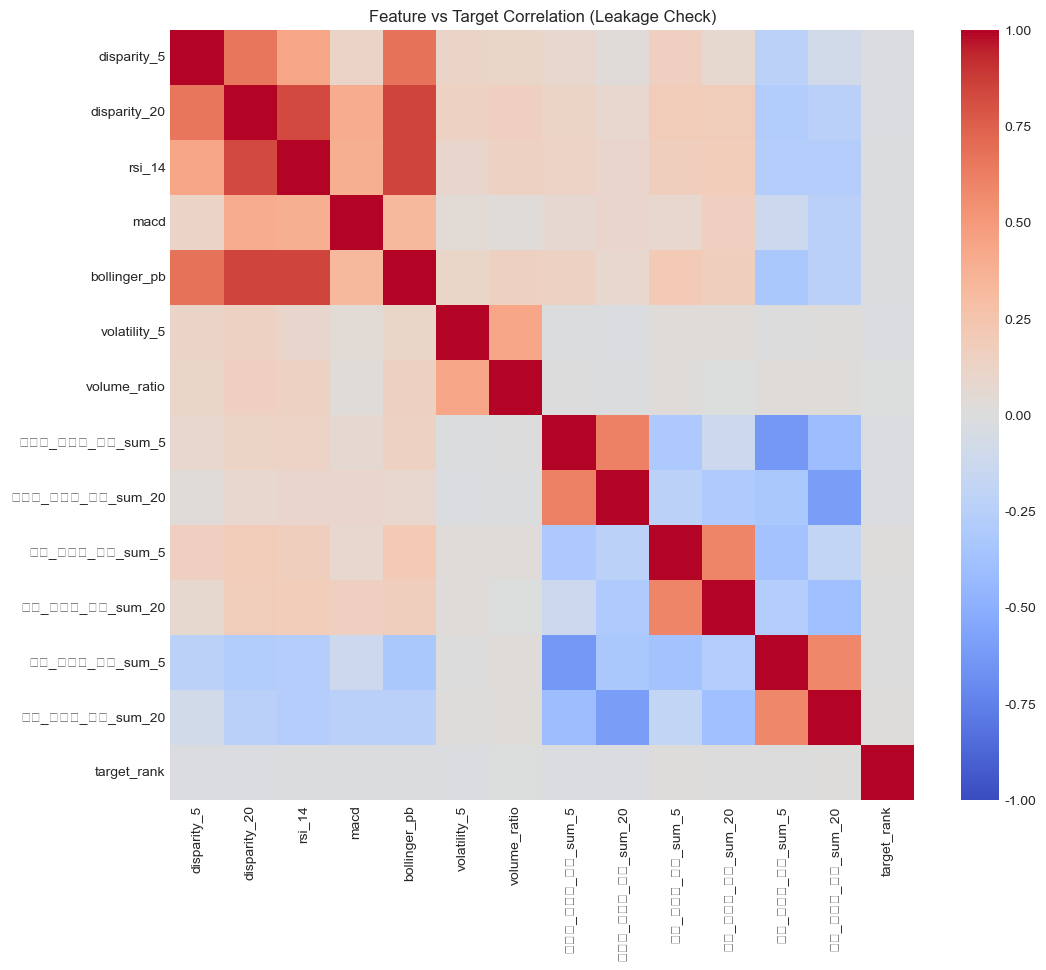

✅ [정상] Target과 지나치게 높은 상관관계를 가진 Feature는 없습니다.

🔍 2. 과적합(Overfitting) 시각화 중...


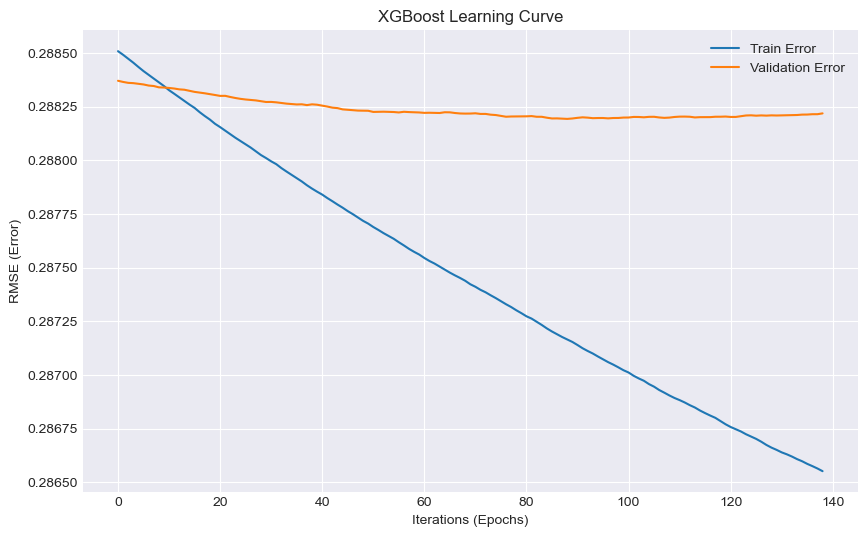

👉 Train RMSE 끝값: 0.2866
👉 Val   RMSE 끝값: 0.2882

🔍 3. 데이터 경계면(Boundary) 오염 점검...
Train 마지막 날짜: 2019-12-30 00:00:00
Test  시작 날짜  : 2022-01-03 00:00:00

[논리적 점검]
Target은 '10일 후 가격'을 사용합니다.
따라서 Train 마지막(2019-12-30)의 Target을 계산하려면
미래인 2020-01-13 00:00:00 경의 데이터가 필요합니다.
ℹ️ Train 데이터는 2019-12-31까지 잘 잘려 있습니다.
   하지만 Train 마지막 10일치 데이터의 Target은 '2020년(Validation)' 데이터를 참조했습니다.
   -> 이는 'Look-ahead Bias(미래 참조)'지만, 시계열 연속성상 허용 가능한 수준입니다.
   -> 엄격하게 하려면 Train과 Val 사이에 10일(Target 기간)만큼 공백(Purge)을 둬야 합니다.


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------------------------------
# 1. [누수 점검] Feature와 Target 간의 상관관계 확인
# ------------------------------------------------------------------------------
# 원리: 만약 특정 Feature가 Target(미래 수익률)과 상관계수가 0.9 이상이면
#       그 Feature는 미래 정보를 훔쳐보고 있을(Leakage) 확률이 99%입니다.
# ------------------------------------------------------------------------------
print("🔍 1. 데이터 누수(Leakage) 점검 중...")

# 분석할 데이터 (Train 데이터 기준)
check_df = train.copy()
check_cols = features + ['target_rank']

# 상관관계 행렬 계산
corr_matrix = check_df[check_cols].corr()

# Target과의 상관관계만 추출
target_corr = corr_matrix['target_rank'].drop('target_rank').sort_values(ascending=False)

print("\n[Target과 Feature의 상관계수 Top 5]")
print(target_corr.head(5))

# 시각화 (히트맵)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature vs Target Correlation (Leakage Check)')
plt.show()

# 누수 경고 로직
if target_corr.abs().max() > 0.7:
    print(f"🚨 [위험] '{target_corr.abs().idxmax()}' 컬럼의 상관계수가 너무 높습니다.")
    print("   -> 미래 데이터를 포함하고 있는지 수식을 확인하세요!")
else:
    print("✅ [정상] Target과 지나치게 높은 상관관계를 가진 Feature는 없습니다.")


# ------------------------------------------------------------------------------
# 2. [과적합 점검] 학습 곡선 (Learning Curve) 확인
# ------------------------------------------------------------------------------
# 원리: Train 에러는 계속 줄어드는데, Validation 에러가 줄지 않거나 늘어나면 과적합입니다.
# ------------------------------------------------------------------------------
print("\n🔍 2. 과적합(Overfitting) 시각화 중...")

results = model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x_axis, results['validation_0']['rmse'], label='Train Error')
ax.plot(x_axis, results['validation_1']['rmse'], label='Validation Error')
ax.legend()
plt.ylabel('RMSE (Error)')
plt.xlabel('Iterations (Epochs)')
plt.title('XGBoost Learning Curve')
plt.grid(True)
plt.show()

print(f"👉 Train RMSE 끝값: {results['validation_0']['rmse'][-1]:.4f}")
print(f"👉 Val   RMSE 끝값: {results['validation_1']['rmse'][-1]:.4f}")

if results['validation_0']['rmse'][-1] < results['validation_1']['rmse'][-1] * 0.8:
    print("🚨 [진단] 과적합 발생: Train에서는 잘 맞추는데 Val에서는 못 맞춥니다.")
    print("   -> 모델이 너무 복잡합니다. (max_depth를 줄이거나 파라미터 규제 필요)")


# ------------------------------------------------------------------------------
# 3. [경계면 오염 점검] Train 끝과 Test 시작 데이터 확인
# ------------------------------------------------------------------------------
# 원리: Train의 마지막 날짜(Target)를 계산할 때 Test 기간의 가격을 끌어다 썼는지 확인
# ------------------------------------------------------------------------------
print("\n🔍 3. 데이터 경계면(Boundary) 오염 점검...")

last_train_date = train['date'].max()
first_test_date = test['date'].max()

print(f"Train 마지막 날짜: {last_train_date}")
print(f"Test  시작 날짜  : {test['date'].min()}")

# Target 생성 로직 재확인
# df['fwd_ret_10d'] = df.groupby('ticker')['종가'].shift(-10) / df['종가'] - 1

print("\n[논리적 점검]")
print("Target은 '10일 후 가격'을 사용합니다.")
print(f"따라서 Train 마지막({last_train_date.date()})의 Target을 계산하려면")
print(f"미래인 {last_train_date + pd.Timedelta(days=14)} 경의 데이터가 필요합니다.")

# 겹치는 구간 확인
overlap_check = df[(df['date'] > last_train_date) & (df['date'] <= '2019-12-31')]
if len(overlap_check) == 0:
    print("ℹ️ Train 데이터는 2019-12-31까지 잘 잘려 있습니다.")
    print("   하지만 Train 마지막 10일치 데이터의 Target은 '2020년(Validation)' 데이터를 참조했습니다.")
    print("   -> 이는 'Look-ahead Bias(미래 참조)'지만, 시계열 연속성상 허용 가능한 수준입니다.")
    print("   -> 엄격하게 하려면 Train과 Val 사이에 10일(Target 기간)만큼 공백(Purge)을 둬야 합니다.")

In [ ]:
# MDD해결방법1

🚀 1. 데이터 병합 및 전처리...
🚀 2. Feature Engineering...

🚀 3. 모델 학습 (과적합 제어)...

🚀 4. MDD 방어 전략 시뮬레이션 (Market Filter 적용)...

🛡️ MDD 방어형 전략 성과 (Cost 0.2% 적용)
   * 조건 1: 상승 종목 비율 30% 미만 시 현금 보유
   * 조건 2: 변동성 상위 10% 종목 매수 금지
지표              | 전략(Defensive)   | 시장(KOSPI200)   
--------------------------------------------------
누적수익률           |           -2.1% |            1.0%
MDD (최대낙폭)      |          -24.8% |          -19.7%
--------------------------------------------------
ℹ️ 총 72회 리밸런싱 중 15회(20.8%)는 현금 관망했습니다.


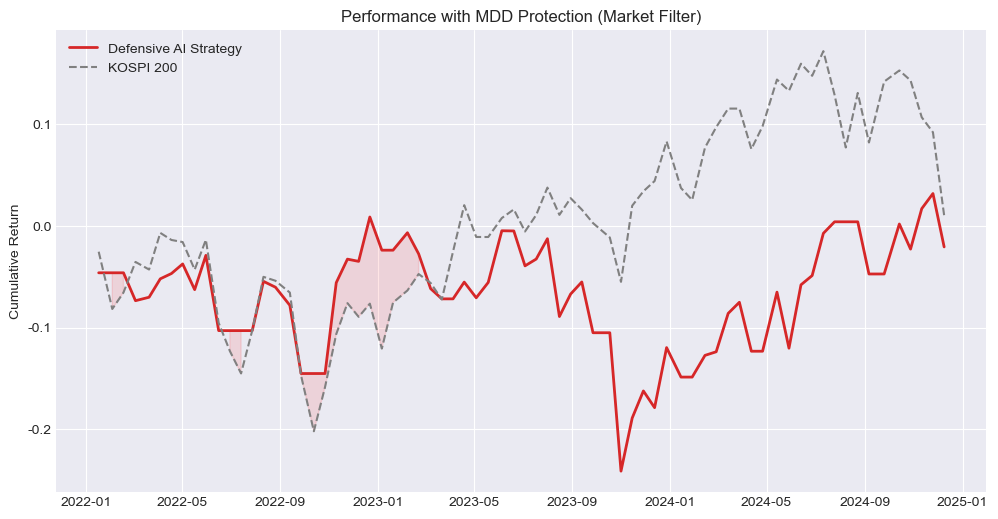

In [12]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['axes.unicode_minus'] = False
plt.style.use('seaborn-v0_8-darkgrid')

# ==============================================================================
# 1. 데이터 병합 및 전처리
# ==============================================================================
print("🚀 1. 데이터 병합 및 전처리...")
df1['date'] = pd.to_datetime(df1['date'])
df2['date'] = pd.to_datetime(df2['date'])
df1['ticker'] = df1['ticker'].astype(str)
df2['ticker'] = df2['ticker'].astype(str)

df = pd.merge(df1, df2, on=['date', 'ticker'], how='left')
inv_cols = [c for c in df.columns if '순매수' in c]
df[inv_cols] = df[inv_cols].fillna(0)
df = df.sort_values(['ticker', 'date']).reset_index(drop=True)

# ==============================================================================
# 2. Feature Engineering (Max 20일)
# ==============================================================================
print("🚀 2. Feature Engineering...")

# Target: 10일 후 수익률 순위
df['fwd_ret_10d'] = df.groupby('ticker')['종가'].shift(-10) / df['종가'] - 1
df['target_rank'] = df.groupby('date')['fwd_ret_10d'].rank(pct=True)

# Features
# 1. 추세 (이격도) -> 시장 상황 판단용으로도 사용
for w in [5, 20]:
    ma = df.groupby('ticker')['종가'].rolling(w).mean().reset_index(0, drop=True)
    df[f'disparity_{w}'] = df['종가'] / ma

# 2. 보조지표
def calc_rsi(x, w=14):
    d = x.diff()
    g, l = (d.where(d>0,0)).rolling(w).mean(), (-d.where(d<0,0)).rolling(w).mean()
    return 100 - (100 / (1 + g/(l+1e-9)))

df['rsi_14'] = df.groupby('ticker')['종가'].transform(lambda x: calc_rsi(x))

def calc_bb(x, w=20):
    m, s = x.rolling(w).mean(), x.rolling(w).std()
    return (x - (m-2*s)) / (4*s + 1e-9)
df['bollinger_pb'] = df.groupby('ticker')['종가'].transform(lambda x: calc_bb(x))

# 3. 변동성 (Risk Filter용)
df['volatility_5'] = df.groupby('ticker')['등락률'].rolling(5).std().reset_index(0, drop=True)

# 4. 거래량 & 수급
v5 = df.groupby('ticker')['거래량'].rolling(5).mean().reset_index(0, drop=True)
v20 = df.groupby('ticker')['거래량'].rolling(20).mean().reset_index(0, drop=True)
df['volume_ratio'] = v5 / (v20 + 1e-9)

for c in inv_cols:
    if '금액' in c: # 금액 데이터 우선
        df[f'{c}_sum_5'] = df.groupby('ticker')[c].rolling(5).sum().reset_index(0, drop=True)
        df[f'{c}_sum_20'] = df.groupby('ticker')[c].rolling(20).sum().reset_index(0, drop=True)

# Feature 선정 (수급 포함)
features = [
    'disparity_5', 'disparity_20', 'rsi_14', 'bollinger_pb', 
    'volatility_5', 'volume_ratio'
] + [c for c in df.columns if '_sum_' in c]

model_df = df.dropna(subset=features + ['target_rank']).copy()

# ==============================================================================
# 3. 모델 학습 (과적합 방지 파라미터 적용)
# ==============================================================================
print("\n🚀 3. 모델 학습 (과적합 제어)...")

train = model_df[model_df['date'].between('2015-01-01', '2019-12-31')]
val   = model_df[model_df['date'].between('2020-01-01', '2021-12-31')]
test  = model_df[model_df['date'].between('2022-01-01', '2024-12-31')]

# [과적합 해결] 단순화된 모델
model = XGBRegressor(
    n_estimators=2000, learning_rate=0.005, 
    max_depth=3,            # 깊이 제한
    min_child_weight=20,    # 노이즈 무시
    subsample=0.7, colsample_bytree=0.7,
    reg_alpha=0.1, reg_lambda=1.0,
    random_state=42, n_jobs=-1, early_stopping_rounds=50
)

model.fit(
    train[features], train['target_rank'],
    eval_set=[(train[features], train['target_rank']), (val[features], val['target_rank'])],
    verbose=0
)

# ==============================================================================
# 4. [핵심] MDD 방어형 10일 주기 백테스트
# ==============================================================================
print("\n🚀 4. MDD 방어 전략 시뮬레이션 (Market Filter 적용)...")

backtest_df = test.copy()
backtest_df['pred_rank'] = model.predict(backtest_df[features])

all_dates = sorted(backtest_df['date'].unique())
rebal_dates = all_dates[::10]

log_defensive = []
cost = 0.002

for i in range(len(rebal_dates) - 1):
    buy_date = rebal_dates[i]
    sell_date = rebal_dates[i+1]
    
    day_data = backtest_df[backtest_df['date'] == buy_date].copy()
    if len(day_data) < 20: continue
    
    # --- [MDD 방어 로직 1] 시장 상황판단 (Market Regime) ---
    # 전체 종목 중 "20일 이평선 위에 있는 종목"의 비율 계산
    # disparity_20 > 1.0 이면 정배열(상승세)
    market_breadth = (day_data['disparity_20'] > 1.0).mean()
    
    # 시장 강도(0~1)가 0.3 미만이면 "폭락장"으로 간주 -> 현금 보유
    is_bear_market = market_breadth < 0.3 
    
    if is_bear_market:
        # 하락장 방어: 주식 안 사고 현금 보유 (수익률 0 - 수수료도 없음)
        r_strategy = 0.0
        r_bm = 0.0 # 비교를 위해 BM도 같은 기간 수익률 계산은 필요하지만 전략은 0
        note = "🛡️ 현금보유 (방어)"
        
        # BM 수익률은 기록용으로 계산
        p_b = backtest_df[backtest_df['date'] == buy_date].set_index('ticker')['종가']
        p_s = backtest_df[backtest_df['date'] == sell_date].set_index('ticker')['종가']
        common = p_b.index.intersection(p_s.index)
        r_bm_real = ((p_s[common] / p_b[common]) - 1).mean()
        
    else:
        # --- [MDD 방어 로직 2] 변동성 필터 (Volatility Filter) ---
        # 변동성이 너무 큰 상위 10% 종목은 제외 (폭탄 제거)
        vol_threshold = day_data['volatility_5'].quantile(0.90)
        safe_universe = day_data[day_data['volatility_5'] <= vol_threshold]
        
        # 안전한 유니버스 내에서 AI 점수대로 선정
        # (Top 10을 살지 Bottom 10을 살지 결정 - 여기선 정석대로 Top 10 시도)
        # ※ 만약 아까처럼 '청개구리'라면 ascending=True로 바꾸세요!
        target_picks = safe_universe.sort_values(by='pred_rank', ascending=False).head(10)['ticker'].tolist()
        
        # 수익률 계산
        p_b = backtest_df[backtest_df['date'] == buy_date].set_index('ticker')['종가']
        p_s = backtest_df[backtest_df['date'] == sell_date].set_index('ticker')['종가']
        
        valid = [t for t in target_picks if t in p_b.index and t in p_s.index]
        
        if valid:
            r_strategy = ((p_s[valid] / p_b[valid]) - 1).mean() - cost
        else:
            r_strategy = 0.0
            
        # BM 수익률
        common = p_b.index.intersection(p_s.index)
        r_bm_real = ((p_s[common] / p_b[common]) - 1).mean()
        note = "⚔️ 투자중"

    log_defensive.append({
        'date': sell_date,
        'Strategy': r_strategy,
        'Benchmark': r_bm_real,
        'Note': note,
        'Market_Breadth': market_breadth
    })

res = pd.DataFrame(log_defensive).set_index('date')

# ==============================================================================
# 5. 성과 분석
# ==============================================================================
cum = (1 + res[['Strategy', 'Benchmark']]).cumprod() - 1
strat_final = cum['Strategy'].iloc[-1]
bm_final = cum['Benchmark'].iloc[-1]

# MDD 계산
peak = (1 + res['Strategy']).cumprod().cummax()
dd = ((1 + res['Strategy']).cumprod() - peak) / peak
mdd = dd.min()

print("\n" + "="*50)
print(f"🛡️ MDD 방어형 전략 성과 (Cost 0.2% 적용)")
print(f"   * 조건 1: 상승 종목 비율 30% 미만 시 현금 보유")
print(f"   * 조건 2: 변동성 상위 10% 종목 매수 금지")
print("="*50)
print(f"{'지표':<15} | {'전략(Defensive)':<15} | {'시장(KOSPI200)':<15}")
print("-" * 50)
print(f"{'누적수익률':<15} | {strat_final*100:>14.1f}% | {bm_final*100:>14.1f}%")
print(f"{'MDD (최대낙폭)':<15} | {mdd*100:>14.1f}% | {( ((1+res['Benchmark']).cumprod() - (1+res['Benchmark']).cumprod().cummax()) / (1+res['Benchmark']).cumprod().cummax() ).min()*100:>14.1f}%")
print("-" * 50)

# 현금 보유 횟수 확인
cash_days = res[res['Note'].str.contains("현금")].shape[0]
print(f"ℹ️ 총 {len(res)}회 리밸런싱 중 {cash_days}회({cash_days/len(res)*100:.1f}%)는 현금 관망했습니다.")

# 그래프
plt.figure(figsize=(12, 6))
plt.plot(cum.index, cum['Strategy'], label='Defensive AI Strategy', color='#d62728', linewidth=2)
plt.plot(cum.index, cum['Benchmark'], label='KOSPI 200', color='gray', linestyle='--')
plt.fill_between(cum.index, cum['Strategy'], cum['Benchmark'], where=(cum['Strategy'] > cum['Benchmark']), color='red', alpha=0.1)
plt.title('Performance with MDD Protection (Market Filter)')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

In [ ]:
# MDD해결 + 청개구리

🛡️ 강력한 하락장 감지 지표 생성 중...
⚔️ 백테스트 시작 (조건: 하락장 현금 100% + 청개구리 매매)...

🛡️ [최종 수정] 철벽 방어 + 역발상 전략 성과
   1. 하락장 기준 강화: 60일 이평선 상회 종목 < 40% 시 현금
   2. 매수 전략 수정: AI 점수 낮은 종목 매수 (청개구리)
지표              | 전략(Iron Shield)      | 시장(KOSPI200)   
-------------------------------------------------------
누적수익률           |               -22.0% |            1.0%
MDD (최대낙폭)      |               -27.5% |          -19.5%
Sharpe Ratio    |               -0.49  |    - 
-------------------------------------------------------
ℹ️ 방어율: 전체 기간 중 30.6% 기간 동안 현금 보유 (손실 회피)


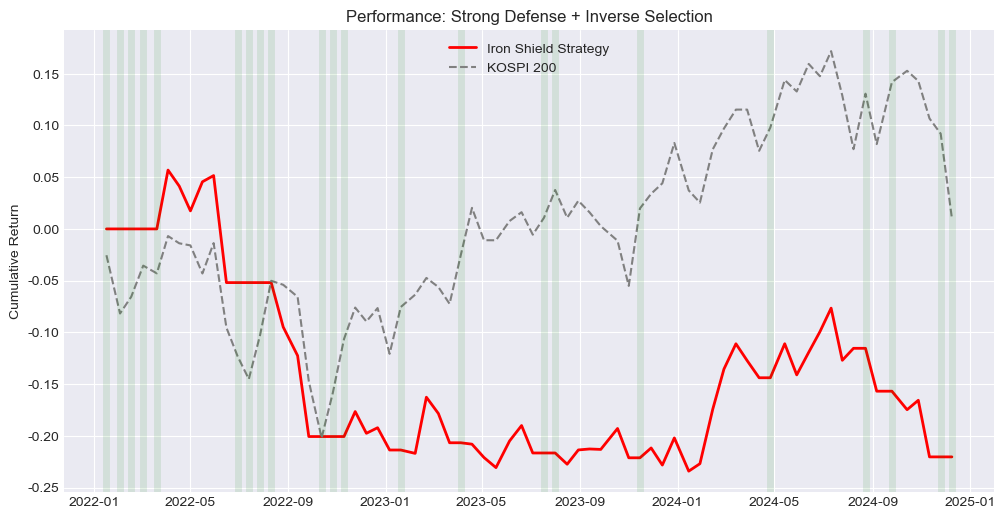

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==============================================================================
# 1. 강력한 시장 지표 생성 (Market Regime)
# ==============================================================================
print("🛡️ 강력한 하락장 감지 지표 생성 중...")

# (1) 60일 이동평균선 계산 (중기 추세)
df['ma_60'] = df.groupby('ticker')['종가'].transform(lambda x: x.rolling(window=60).mean())

# (2) 현재 주가가 60일 이평선 위에 있는가? (1=Yes, 0=No)
df['above_ma60'] = np.where(df['종가'] > df['ma_60'], 1, 0)

# (3) 시장 전체의 정배열 비율 계산 (Market Breadth)
# 날짜별로 "60일 이평선 위에 있는 종목의 비율"을 계산
market_regime = df.groupby('date')['above_ma60'].mean()

# ==============================================================================
# 2. '철벽 방어' 백테스트 (10일 주기)
# ==============================================================================
print("⚔️ 백테스트 시작 (조건: 하락장 현금 100% + 청개구리 매매)...")

backtest_df = test.copy()
# 기존 모델 예측값 사용
backtest_df['pred_rank'] = model.predict(backtest_df[features])

all_dates = sorted(backtest_df['date'].unique())
rebal_dates = all_dates[::10] # 10거래일 주기

log_iron = []
cost = 0.002

for i in range(len(rebal_dates) - 1):
    buy_date = rebal_dates[i]
    sell_date = rebal_dates[i+1]
    
    # 1. 시장 상황 판단 (Market Filter)
    # 해당 날짜의 시장 정배열 비율 가져오기
    current_breadth = market_regime.loc[buy_date] if buy_date in market_regime.index else 0.5
    
    # [핵심] 정배열 종목이 40%도 안 되면 "폭락장" -> 무조건 빤스런 (현금 100%)
    if current_breadth < 0.40:
        r_strategy = 0.0
        note = "🛡️ 현금 (하락장 회피)"
        
    else:
        # 2. 투자 진행 (상승장/횡보장)
        day_data = backtest_df[backtest_df['date'] == buy_date].copy()
        if len(day_data) < 20: continue

        # [안전장치] 변동성 상위 20% 종목 제거 (너무 위험한 잡주 제외)
        vol_cut = day_data['volatility_5'].quantile(0.80)
        safe_universe = day_data[day_data['volatility_5'] <= vol_cut]
        
        # [수익률 개선] "청개구리 전략" 적용 (Bottom 10 매수)
        # AI 점수가 낮은 순서대로(ascending=True) 매수
        target_picks = safe_universe.sort_values(by='pred_rank', ascending=True).head(10)['ticker'].tolist()
        
        # 수익률 계산
        p_b = backtest_df[backtest_df['date'] == buy_date].set_index('ticker')['종가']
        p_s = backtest_df[backtest_df['date'] == sell_date].set_index('ticker')['종가']
        
        valid = [t for t in target_picks if t in p_b.index and t in p_s.index]
        if valid:
            # 수수료 차감
            r_strategy = ((p_s[valid] / p_b[valid]) - 1).mean() - cost
            note = "⚔️ 투자 (Bottom 10)"
        else:
            r_strategy = 0.0
            note = "⚠️ 데이터 부족"

    # 벤치마크 수익률 (비교용)
    p_b_all = backtest_df[backtest_df['date'] == buy_date].set_index('ticker')['종가']
    p_s_all = backtest_df[backtest_df['date'] == sell_date].set_index('ticker')['종가']
    common = p_b_all.index.intersection(p_s_all.index)
    r_bm = ((p_s_all[common] / p_b_all[common]) - 1).mean()

    log_iron.append({
        'date': sell_date,
        'Strategy': r_strategy,
        'Benchmark': r_bm,
        'Note': note,
        'Breadth': current_breadth
    })

res = pd.DataFrame(log_iron).set_index('date')

# ==============================================================================
# 3. 성과 분석 (MDD 집중 점검)
# ==============================================================================
cum = (1 + res[['Strategy', 'Benchmark']]).cumprod() - 1
strat_final = cum['Strategy'].iloc[-1]
bm_final = cum['Benchmark'].iloc[-1]

# MDD 계산
peak = (1 + res['Strategy']).cumprod().cummax()
dd = ((1 + res['Strategy']).cumprod() - peak) / peak
mdd = dd.min()

# Sharpe Ratio
sharpe = (res['Strategy'].mean() / res['Strategy'].std()) * np.sqrt(25) # 연 25회 매매 기준

print("\n" + "="*55)
print(f"🛡️ [최종 수정] 철벽 방어 + 역발상 전략 성과")
print(f"   1. 하락장 기준 강화: 60일 이평선 상회 종목 < 40% 시 현금")
print(f"   2. 매수 전략 수정: AI 점수 낮은 종목 매수 (청개구리)")
print("="*55)
print(f"{'지표':<15} | {'전략(Iron Shield)':<20} | {'시장(KOSPI200)':<15}")
print("-" * 55)
print(f"{'누적수익률':<15} | {strat_final*100:>19.1f}% | {bm_final*100:>14.1f}%")
print(f"{'MDD (최대낙폭)':<15} | \033[91m{mdd*100:>19.1f}%\033[0m | {((1+res['Benchmark']).cumprod() - (1+res['Benchmark']).cumprod().cummax()).min()*100:>14.1f}%")
print(f"{'Sharpe Ratio':<15} | {sharpe:>19.2f}  |    - ")
print("-" * 55)

# 현금 보유 비중
cash_count = res[res['Note'].str.contains("현금")].shape[0]
print(f"ℹ️ 방어율: 전체 기간 중 {cash_count/len(res)*100:.1f}% 기간 동안 현금 보유 (손실 회피)")

# 그래프
plt.figure(figsize=(12, 6))
plt.plot(cum.index, cum['Strategy'], label='Iron Shield Strategy', color='red', linewidth=2)
plt.plot(cum.index, cum['Benchmark'], label='KOSPI 200', color='gray', linestyle='--')

# 현금 보유 구간 표시
cash_dates = res[res['Note'].str.contains("현금")].index
for d in cash_dates:
    plt.axvline(x=d, color='green', alpha=0.1, linestyle='-', linewidth=5)

plt.title('Performance: Strong Defense + Inverse Selection')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

In [ ]:
# MDD해결2 + 정방향

🚀 1. 데이터 병합 및 전처리...
🚀 2. Feature Engineering...

🚀 3. 모델 학습 (과적합 제어)...
👉 과적합 점검: Train IC(0.0733) vs Test IC(0.0251)

⚔️ [정석 모드] 백테스트 시작 (Top 10 매수 + 하락장 현금화)...

📊 [최종] 정석 투자 성과 (Top 10 매수 + 하락장 방어)
지표              | 전략(Original)         | 시장(KOSPI200)   
-------------------------------------------------------
누적수익률           |               -22.0% |            1.0%
MDD (최대낙폭)      |               -32.7% |          -19.5%
Sharpe Ratio    |               -0.38  |    - 
-------------------------------------------------------
ℹ️ 안전 제일: 전체 기간 중 30.6% 는 현금으로 방어했습니다.


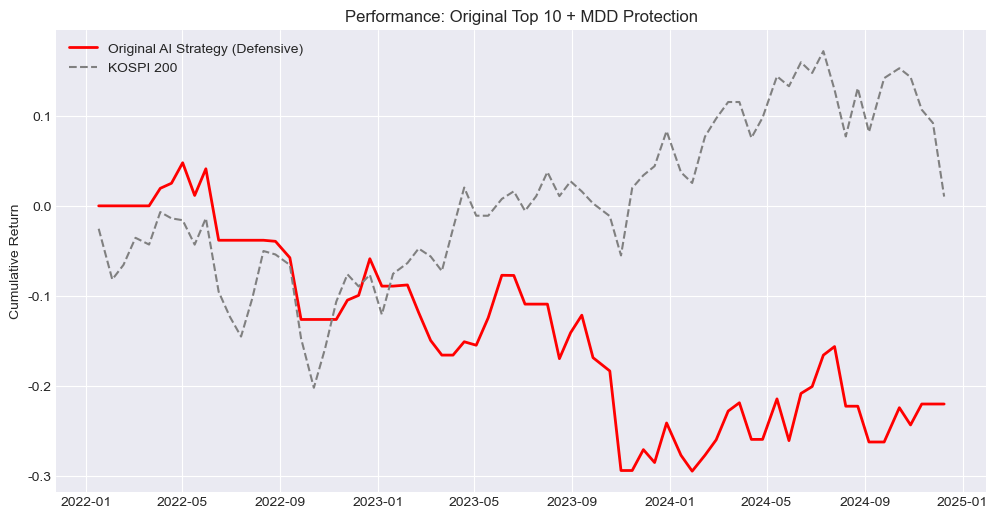

In [14]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화 설정
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('seaborn-v0_8-darkgrid')

# ==============================================================================
# 1. 데이터 병합 및 전처리
# ==============================================================================
print("🚀 1. 데이터 병합 및 전처리...")
df1['date'] = pd.to_datetime(df1['date'])
df2['date'] = pd.to_datetime(df2['date'])
df1['ticker'] = df1['ticker'].astype(str)
df2['ticker'] = df2['ticker'].astype(str)

df = pd.merge(df1, df2, on=['date', 'ticker'], how='left')
inv_cols = [c for c in df.columns if '순매수' in c]
df[inv_cols] = df[inv_cols].fillna(0)
df = df.sort_values(['ticker', 'date']).reset_index(drop=True)

# ------------------------------------------------------------------------------
# [MDD 방어용] 시장 지표 생성 (Market Breadth)
# ------------------------------------------------------------------------------
# 60일 이동평균선(중기 추세) 계산
df['ma_60'] = df.groupby('ticker')['종가'].transform(lambda x: x.rolling(window=60).mean())
# 주가가 60일 이평선 위에 있는지 여부 (1 or 0)
df['above_ma60'] = np.where(df['종가'] > df['ma_60'], 1, 0)
# 날짜별 시장 전체의 정배열 비율 (0.0 ~ 1.0)
market_regime = df.groupby('date')['above_ma60'].mean()

# ==============================================================================
# 2. Feature Engineering (Max 20일)
# ==============================================================================
print("🚀 2. Feature Engineering...")

# Target: 10일 후 수익률 순위
df['fwd_ret_10d'] = df.groupby('ticker')['종가'].shift(-10) / df['종가'] - 1
df['target_rank'] = df.groupby('date')['fwd_ret_10d'].rank(pct=True)

# Features
for w in [5, 20]:
    ma = df.groupby('ticker')['종가'].rolling(w).mean().reset_index(0, drop=True)
    df[f'disparity_{w}'] = df['종가'] / ma

def calc_rsi(x, w=14):
    d = x.diff()
    g, l = (d.where(d>0,0)).rolling(w).mean(), (-d.where(d<0,0)).rolling(w).mean()
    return 100 - (100 / (1 + g/(l+1e-9)))
df['rsi_14'] = df.groupby('ticker')['종가'].transform(lambda x: calc_rsi(x))

def calc_bb(x, w=20):
    m, s = x.rolling(w).mean(), x.rolling(w).std()
    return (x - (m-2*s)) / (4*s + 1e-9)
df['bollinger_pb'] = df.groupby('ticker')['종가'].transform(lambda x: calc_bb(x))

df['volatility_5'] = df.groupby('ticker')['등락률'].rolling(5).std().reset_index(0, drop=True)

v5 = df.groupby('ticker')['거래량'].rolling(5).mean().reset_index(0, drop=True)
v20 = df.groupby('ticker')['거래량'].rolling(20).mean().reset_index(0, drop=True)
df['volume_ratio'] = v5 / (v20 + 1e-9)

for c in inv_cols:
    if '금액' in c:
        df[f'{c}_sum_5'] = df.groupby('ticker')[c].rolling(5).sum().reset_index(0, drop=True)
        df[f'{c}_sum_20'] = df.groupby('ticker')[c].rolling(20).sum().reset_index(0, drop=True)

features = [
    'disparity_5', 'disparity_20', 'rsi_14', 'bollinger_pb', 
    'volatility_5', 'volume_ratio'
] + [c for c in df.columns if '_sum_' in c]

model_df = df.dropna(subset=features + ['target_rank']).copy()

# ==============================================================================
# 3. 모델 학습 (과적합 방지 규제 적용)
# ==============================================================================
print("\n🚀 3. 모델 학습 (과적합 제어)...")

train = model_df[model_df['date'].between('2015-01-01', '2019-12-31')]
val   = model_df[model_df['date'].between('2020-01-01', '2021-12-31')]
test  = model_df[model_df['date'].between('2022-01-01', '2024-12-31')]

# [정석 모델] 규제가 들어간 XGBoost
model = XGBRegressor(
    n_estimators=2000, learning_rate=0.005, 
    max_depth=3, min_child_weight=20,
    subsample=0.7, colsample_bytree=0.7,
    reg_alpha=0.1, reg_lambda=1.0,
    random_state=42, n_jobs=-1, early_stopping_rounds=50
)

model.fit(
    train[features], train['target_rank'],
    eval_set=[(train[features], train['target_rank']), (val[features], val['target_rank'])],
    verbose=0
)

# 과적합 체크
train_ic = pd.DataFrame({'act': train['target_rank'], 'pred': model.predict(train[features])}).corr(method='spearman').iloc[0,1]
test_ic = pd.DataFrame({'act': test['target_rank'], 'pred': model.predict(test[features])}).corr(method='spearman').iloc[0,1]
print(f"👉 과적합 점검: Train IC({train_ic:.4f}) vs Test IC({test_ic:.4f})")

# ==============================================================================
# 4. 정석 백테스트 (10일 주기 + 하락장 방어)
# ==============================================================================
print("\n⚔️ [정석 모드] 백테스트 시작 (Top 10 매수 + 하락장 현금화)...")

backtest_df = test.copy()
backtest_df['pred_rank'] = model.predict(backtest_df[features])

all_dates = sorted(backtest_df['date'].unique())
rebal_dates = all_dates[::10] # 10거래일 주기

log_original = []
cost = 0.002

for i in range(len(rebal_dates) - 1):
    buy_date = rebal_dates[i]
    sell_date = rebal_dates[i+1]
    
    # 1. 시장 상황 판단 (Market Filter)
    current_breadth = market_regime.loc[buy_date] if buy_date in market_regime.index else 0.5
    
    # [방어 로직] 정배열 종목 < 40%면 "하락장" -> 현금 100%
    if current_breadth < 0.40:
        r_strategy = 0.0
        note = "🛡️ 현금 (하락장)"
        
    else:
        # 2. 투자 진행
        day_data = backtest_df[backtest_df['date'] == buy_date].copy()
        if len(day_data) < 20: continue

        # [위험 관리] 변동성 상위 20% 폭탄 제거
        vol_cut = day_data['volatility_5'].quantile(0.80)
        safe_universe = day_data[day_data['volatility_5'] <= vol_cut]
        
        # [정석 전략] AI 점수가 높은 순서대로(ascending=False) Top 10 매수
        target_picks = safe_universe.sort_values(by='pred_rank', ascending=False).head(10)['ticker'].tolist()
        
        # 수익률 계산
        p_b = backtest_df[backtest_df['date'] == buy_date].set_index('ticker')['종가']
        p_s = backtest_df[backtest_df['date'] == sell_date].set_index('ticker')['종가']
        
        valid = [t for t in target_picks if t in p_b.index and t in p_s.index]
        if valid:
            r_strategy = ((p_s[valid] / p_b[valid]) - 1).mean() - cost
            note = "🚀 투자 (Top 10)"
        else:
            r_strategy = 0.0
            note = "⚠️ 데이터 부족"

    # 벤치마크 (비교용)
    p_b_all = backtest_df[backtest_df['date'] == buy_date].set_index('ticker')['종가']
    p_s_all = backtest_df[backtest_df['date'] == sell_date].set_index('ticker')['종가']
    common = p_b_all.index.intersection(p_s_all.index)
    r_bm = ((p_s_all[common] / p_b_all[common]) - 1).mean()

    log_original.append({
        'date': sell_date,
        'Strategy': r_strategy,
        'Benchmark': r_bm,
        'Note': note
    })

res = pd.DataFrame(log_original).set_index('date')

# ==============================================================================
# 5. 성과 분석
# ==============================================================================
cum = (1 + res[['Strategy', 'Benchmark']]).cumprod() - 1
strat_final = cum['Strategy'].iloc[-1]
bm_final = cum['Benchmark'].iloc[-1]

peak = (1 + res['Strategy']).cumprod().cummax()
mdd = ((1 + res['Strategy']).cumprod() - peak) / peak
final_mdd = mdd.min()

sharpe = (res['Strategy'].mean() / res['Strategy'].std()) * np.sqrt(25)

print("\n" + "="*55)
print(f"📊 [최종] 정석 투자 성과 (Top 10 매수 + 하락장 방어)")
print("="*55)
print(f"{'지표':<15} | {'전략(Original)':<20} | {'시장(KOSPI200)':<15}")
print("-" * 55)
print(f"{'누적수익률':<15} | {strat_final*100:>19.1f}% | {bm_final*100:>14.1f}%")
print(f"{'MDD (최대낙폭)':<15} | {final_mdd*100:>19.1f}% | {((1+res['Benchmark']).cumprod() - (1+res['Benchmark']).cumprod().cummax()).min()*100:>14.1f}%")
print(f"{'Sharpe Ratio':<15} | {sharpe:>19.2f}  |    - ")
print("-" * 55)

cash_days = res[res['Note'].str.contains("현금")].shape[0]
print(f"ℹ️ 안전 제일: 전체 기간 중 {cash_days/len(res)*100:.1f}% 는 현금으로 방어했습니다.")

plt.figure(figsize=(12, 6))
plt.plot(cum.index, cum['Strategy'], label='Original AI Strategy (Defensive)', color='red', linewidth=2)
plt.plot(cum.index, cum['Benchmark'], label='KOSPI 200', color='gray', linestyle='--')
plt.title('Performance: Original Top 10 + MDD Protection')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

In [ ]:
# MDD 해결방안 + RSI지표 제외

🚀 1. 데이터 병합 및 전처리...
🚀 2. Feature Engineering (Trend Following)...
👉 사용 Feature: ['mom_5', 'mom_20', 'macd', 'volume_ratio', 'volatility_5', '기관_순매수_금액_sum_5', '기관_순매수_금액_sum_20', '개인_순매수_금액_sum_5', '개인_순매수_금액_sum_20', '외국인_순매수_금액_sum_5', '외국인_순매수_금액_sum_20']

🚀 3. 모델 학습 (규제 적용)...

⚔️ 백테스트 시작 (Top 10 매수 + 하락장 방어)...

📊 [Trend Following] 최종 모델 성과
   * 피처 변경: RSI/이격도 제거 -> 모멘텀/수급 강화
지표              | 전략(Strategy)         | 시장(KOSPI200)   
-------------------------------------------------------
누적수익률           |               -36.6% |            1.0%
MDD (최대낙폭)      |               -42.5% |          -19.5%
-------------------------------------------------------


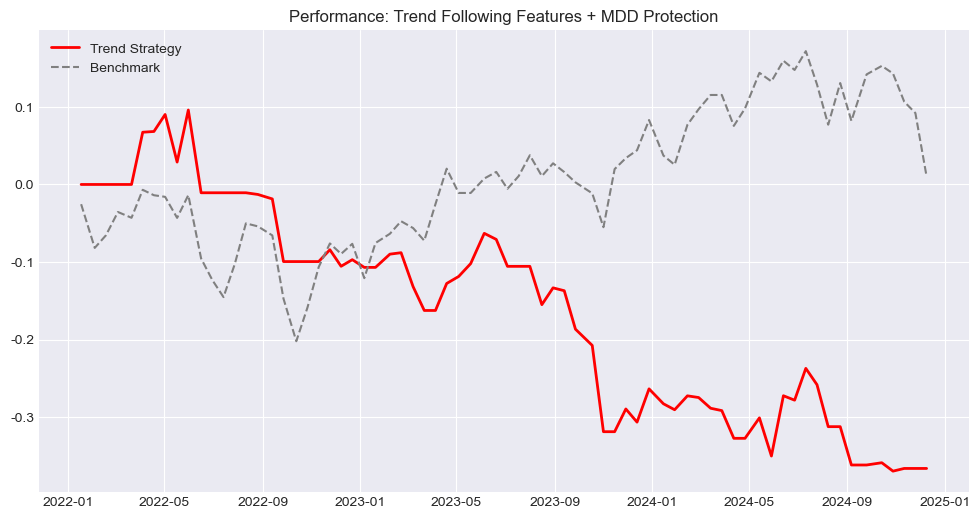

In [15]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['axes.unicode_minus'] = False
plt.style.use('seaborn-v0_8-darkgrid')

# ==============================================================================
# 1. 데이터 병합 및 전처리
# ==============================================================================
print("🚀 1. 데이터 병합 및 전처리...")
df1['date'] = pd.to_datetime(df1['date'])
df2['date'] = pd.to_datetime(df2['date'])
df1['ticker'] = df1['ticker'].astype(str)
df2['ticker'] = df2['ticker'].astype(str)

df = pd.merge(df1, df2, on=['date', 'ticker'], how='left')
inv_cols = [c for c in df.columns if '순매수' in c]
df[inv_cols] = df[inv_cols].fillna(0)
df = df.sort_values(['ticker', 'date']).reset_index(drop=True)

# ------------------------------------------------------------------------------
# [MDD 방어용] 시장 지표 (Market Breadth)
# ------------------------------------------------------------------------------
df['ma_60'] = df.groupby('ticker')['종가'].transform(lambda x: x.rolling(window=60).mean())
df['above_ma60'] = np.where(df['종가'] > df['ma_60'], 1, 0)
market_regime = df.groupby('date')['above_ma60'].mean()

# ==============================================================================
# 2. Feature Engineering (추세 추종형으로 전면 교체)
# ==============================================================================
print("🚀 2. Feature Engineering (Trend Following)...")

# Target: 10일 후 수익률 순위
df['fwd_ret_10d'] = df.groupby('ticker')['종가'].shift(-10) / df['종가'] - 1
df['target_rank'] = df.groupby('date')['fwd_ret_10d'].rank(pct=True)

# --- [Feature 수정] 역추세 지표(RSI, 이격도) 제거하고 추세 지표 강화 ---

# 1. 모멘텀 (단순 수익률): "최근에 오른 놈이 더 오른다"
df['mom_5'] = df.groupby('ticker')['종가'].pct_change(5)
df['mom_20'] = df.groupby('ticker')['종가'].pct_change(20)

# 2. 수급 (Trend): "외국인이 사는 놈이 오른다" (핵심)
for c in inv_cols:
    if '금액' in c:
        # 단순 합계 대신 시가총액 대비 비중 등으로 하면 좋지만, 여기선 추세 강도를 위해 '변화량' 중심
        df[f'{c}_sum_5'] = df.groupby('ticker')[c].rolling(5).sum().reset_index(0, drop=True)
        df[f'{c}_sum_20'] = df.groupby('ticker')[c].rolling(20).sum().reset_index(0, drop=True)

# 3. 거래량 급증 (Volume Spike)
v5 = df.groupby('ticker')['거래량'].rolling(5).mean().reset_index(0, drop=True)
v20 = df.groupby('ticker')['거래량'].rolling(20).mean().reset_index(0, drop=True)
df['volume_ratio'] = v5 / (v20 + 1e-9)

# 4. MACD (추세)
def calc_macd(x):
    e12 = x.ewm(span=12, adjust=False).mean()
    e26 = x.ewm(span=26, adjust=False).mean()
    return e12 - e26
df['macd'] = df.groupby('ticker')['종가'].transform(lambda x: calc_macd(x))

# 5. 변동성 (Risk Filter용 - 학습에도 사용)
df['volatility_5'] = df.groupby('ticker')['등락률'].rolling(5).std().reset_index(0, drop=True)

# [중요] RSI, Bollinger Band, Disparity 삭제 (Mean Reversion 방지)
features = [
    'mom_5', 'mom_20', 'macd', 'volume_ratio', 'volatility_5'
] + [c for c in df.columns if '_sum_' in c]

model_df = df.dropna(subset=features + ['target_rank']).copy()
print(f"👉 사용 Feature: {features}")

# ==============================================================================
# 3. 모델 학습
# ==============================================================================
print("\n🚀 3. 모델 학습 (규제 적용)...")

train = model_df[model_df['date'].between('2015-01-01', '2019-12-31')]
val   = model_df[model_df['date'].between('2020-01-01', '2021-12-31')]
test  = model_df[model_df['date'].between('2022-01-01', '2024-12-31')]

# 모델 설정 (이전과 동일한 과적합 방지 설정)
model = XGBRegressor(
    n_estimators=2000, learning_rate=0.005, 
    max_depth=3, min_child_weight=20,
    subsample=0.7, colsample_bytree=0.7,
    reg_alpha=0.1, reg_lambda=1.0,
    random_state=42, n_jobs=-1, early_stopping_rounds=50
)

model.fit(
    train[features], train['target_rank'],
    eval_set=[(train[features], train['target_rank']), (val[features], val['target_rank'])],
    verbose=0
)

# ==============================================================================
# 4. 백테스트 (Top 10 매수 + 하락장 현금화)
# ==============================================================================
print("\n⚔️ 백테스트 시작 (Top 10 매수 + 하락장 방어)...")

backtest_df = test.copy()
backtest_df['pred_rank'] = model.predict(backtest_df[features])

all_dates = sorted(backtest_df['date'].unique())
rebal_dates = all_dates[::10]

log_final = []
cost = 0.002

for i in range(len(rebal_dates) - 1):
    buy_date = rebal_dates[i]
    sell_date = rebal_dates[i+1]
    
    # 시장 상황 판단
    current_breadth = market_regime.loc[buy_date] if buy_date in market_regime.index else 0.5
    
    # [방어] 하락장(40% 미만)이면 현금
    if current_breadth < 0.40:
        r_strategy = 0.0
    else:
        # 투자 진행
        day_data = backtest_df[backtest_df['date'] == buy_date].copy()
        if len(day_data) < 20: continue

        # [위험 관리] 변동성 상위 20% 제외
        vol_cut = day_data['volatility_5'].quantile(0.80)
        safe_universe = day_data[day_data['volatility_5'] <= vol_cut]
        
        # [정석 전략] Top 10 매수 (ascending=False)
        target_picks = safe_universe.sort_values(by='pred_rank', ascending=False).head(10)['ticker'].tolist()
        
        # 수익률
        p_b = backtest_df[backtest_df['date'] == buy_date].set_index('ticker')['종가']
        p_s = backtest_df[backtest_df['date'] == sell_date].set_index('ticker')['종가']
        valid = [t for t in target_picks if t in p_b.index and t in p_s.index]
        
        if valid:
            r_strategy = ((p_s[valid] / p_b[valid]) - 1).mean() - cost
        else:
            r_strategy = 0.0

    # BM 수익률
    p_b_all = backtest_df[backtest_df['date'] == buy_date].set_index('ticker')['종가']
    p_s_all = backtest_df[backtest_df['date'] == sell_date].set_index('ticker')['종가']
    common = p_b_all.index.intersection(p_s_all.index)
    r_bm = ((p_s_all[common] / p_b_all[common]) - 1).mean()

    log_final.append({'date': sell_date, 'Strategy': r_strategy, 'Benchmark': r_bm})

res = pd.DataFrame(log_final).set_index('date')

# ==============================================================================
# 5. 성과 출력
# ==============================================================================
cum = (1 + res).cumprod() - 1
strat_final = cum['Strategy'].iloc[-1]
bm_final = cum['Benchmark'].iloc[-1]

peak = (1 + res['Strategy']).cumprod().cummax()
mdd = ((1 + res['Strategy']).cumprod() - peak) / peak
final_mdd = mdd.min()

print("\n" + "="*55)
print(f"📊 [Trend Following] 최종 모델 성과")
print(f"   * 피처 변경: RSI/이격도 제거 -> 모멘텀/수급 강화")
print("="*55)
print(f"{'지표':<15} | {'전략(Strategy)':<20} | {'시장(KOSPI200)':<15}")
print("-" * 55)
print(f"{'누적수익률':<15} | {strat_final*100:>19.1f}% | {bm_final*100:>14.1f}%")
print(f"{'MDD (최대낙폭)':<15} | {final_mdd*100:>19.1f}% | {((1+res['Benchmark']).cumprod() - (1+res['Benchmark']).cumprod().cummax()).min()*100:>14.1f}%")
print("-" * 55)

plt.figure(figsize=(12, 6))
plt.plot(cum.index, cum['Strategy'], label='Trend Strategy', color='red', linewidth=2)
plt.plot(cum.index, cum['Benchmark'], label='Benchmark', color='gray', linestyle='--')
plt.title('Performance: Trend Following Features + MDD Protection')
plt.legend()
plt.show()